# 1. Define function


**Reclassification Logic**

The `relclass` function reclassifies ESA CCI land cover classes into simplified categories:

| New Class | Description | Original ESA CCI Classes |
|-----------|-------------|--------------------------|
| 1 | Cropland | 10-40 |
| 2 | Forest | 50-90, 160, 170 |
| 3 | Savanna | 100, 110 |
| 4 | Shrub | 120, 121, 122 |
| 5 | Grassland and Arid Ecosystem | 130-153 |
| 6 | Wetland | 180 |
| 7 | Built-up | 190 |
| 8 | Bare Area and Ice | 200, 201, 202 |
| 9 | Water | 210 |


In [1]:
import xarray as xr
import glob
import os
import numpy as np
from dask.diagnostics import ProgressBar

#220


def relclass(landcover_ds):
    # 创建一个新的Dataset
    reclassed = landcover_ds.copy()
    
    # 获取要处理的变量
    landcover_da = landcover_ds['lccs_class']

    #cropland
    cropland_mask = (landcover_da >= 10) & (landcover_da <= 40)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~cropland_mask, 1)
    
    #forest
    forest_mask = ((landcover_da >= 50) & (landcover_da <= 90)) \
                  | (landcover_da == 160) | (landcover_da == 170)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~forest_mask, 2)
    
    #savanna
    savanna_mask = (landcover_da == 100) | (landcover_da == 110)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~savanna_mask, 3)
    
    #shrub
    shrub_mask = (landcover_da == 120) | (landcover_da == 121) | (landcover_da == 122)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~shrub_mask, 4)
    
    #grassland and arid ecosystem
    grassland_mask = ((landcover_da >= 130) & (landcover_da <= 153))
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~grassland_mask, 5)
    
    #wetland
    wetland_mask = (landcover_da == 180)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~wetland_mask, 6)
    
    #built-up
    built_up_mask = (landcover_da == 190)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~built_up_mask, 7)
    
    #bare area and ice
    bare_area_mask = (landcover_da == 200) | (landcover_da == 201) | (landcover_da == 202) |(landcover_da == 220)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~bare_area_mask, 8)
    
    #water
    water_mask = (landcover_da == 210)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~water_mask, 9)

    return reclassed

# 定义统一的chunk大小
CHUNK_SIZE = 'auto'  # 使用文件原有的chunk大小

# 读取数据
lc = xr.open_dataset(
    'data/merged_lccs.nc',
    chunks=CHUNK_SIZE
)

# 重分类处理
reclassed_ds = relclass(lc)

# 设置输出路径
output_path = 'output/recalss_lccs.nc'

# 使用dask进行计算并保存
with ProgressBar():
    reclassed_ds.to_netcdf(
        output_path,
        engine="netcdf4",
        format="NETCDF4",
        encoding={"lccs_class": {"zlib": True, "complevel": 4}},
        compute=True
    )

print("Saved the reclassed result!")

[########################################] | 100% Completed | 57m 11s
Saved the reclassed result!


## Create California place as example

In [2]:
import xarray as xr
import glob
import os
import numpy as np
from dask.diagnostics import ProgressBar
reclassed_ds= xr.open_dataset('output/merged_lccs.nc')
# Define California's approximate bounding box
ca_lat_min, ca_lat_max = 32.5, 42.0  # California's latitude range
ca_lon_min, ca_lon_max = -124.5, -114.0  # California's longitude range

# Slice the dataset to California's extent
ca_ds = reclassed_ds.sel(
    lat=slice(ca_lat_max, ca_lat_min),  # Note: slice goes from high to low for lat
    lon=slice(ca_lon_min, ca_lon_max)
)
bare_area_mask = (ca_ds["lccs_class"] == 220)
ca_ds['lccs_class'] = ca_ds['lccs_class'].where(~bare_area_mask, 8)
ca_ds.compute()
# Display the sliced dataset
ca_ds.where(ca_ds["lccs_class"] <= 9).to_netcdf("output/ca_lccs.nc")

# 2. Investigation (Study Area)

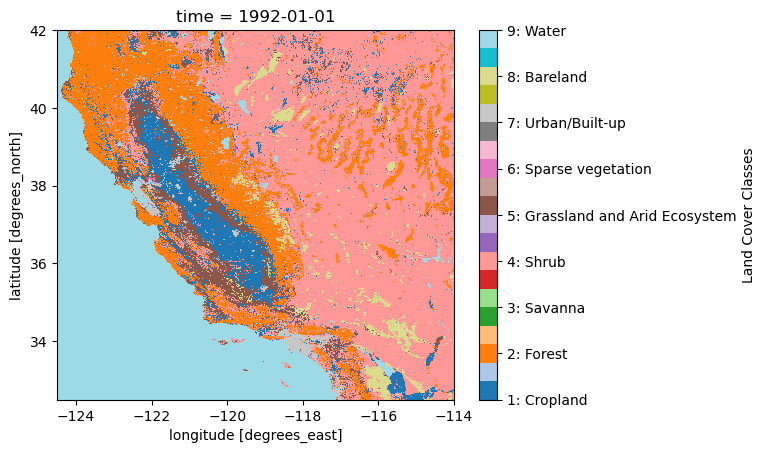

In [16]:
import xarray as xr
import glob
import os
import numpy as np

ca_ds = xr.open_dataset("output/ca_lccs.nc")

# Create a dictionary mapping class values to descriptions
class_descriptions = {
    1: 'Cropland',
    2: 'Forest', 
    3: 'Savanna',
    4: 'Shrub',
    5: 'Grassland and Arid Ecosystem',
    6: 'Sparse vegetation',
    7: 'Urban/Built-up',
    8: 'Bareland',
    9: 'Water'
}

# Plot with custom colormap and legend
plot = ca_ds["lccs_class"].isel(time=0).plot(
    cmap='tab20',
    add_colorbar=True,
    cbar_kwargs={
        'label': 'Land Cover Classes',
        'ticks': list(class_descriptions.keys()),
        'format': lambda x, p: f'{int(x)}: {class_descriptions.get(int(x), "")}'
    }
)





### 农田

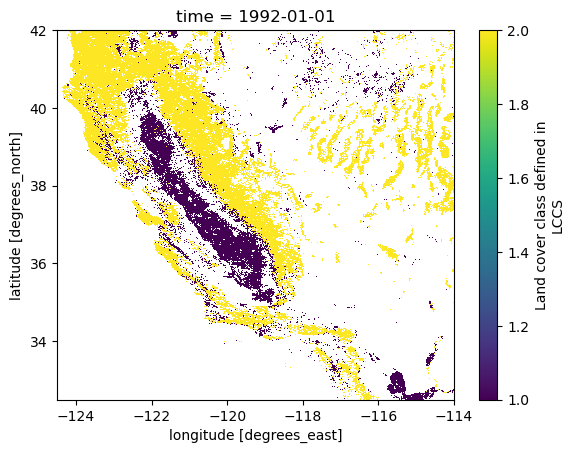

In [17]:
plot = ca_ds["lccs_class"].where((ca_ds["lccs_class"] == 1) | (ca_ds["lccs_class"] == 2)).isel(time=0).plot()

# 3. Identify the cropland abandonment



Given : xarray dataset rc，
It has following properties:
    Dimensions: time: 31 lat: 3420  lon: 3780
    data variable (int)：lccs_class
    Where cropland is 1.
    

Let 非人工区域(non_artificial)为（not cropland (1) nor 7 (built-up)）

Create a new dataset Output: rc_new it has "abandonment_year", abandonment_duration


1. 检测所有满足下列条件的像素生成mask:
   1. 所有年里存在农田(1)
   2. non_artificial 的数量应>=5
   3. 至少存在第一个点是1，第二个点是non_artificial的情况


2. 根据这个mask， 遍历所有满足条件的像素tqdm(series)

For each point in series:
    duration=0
    year=None
    if the point is cropland:
        if duration >=5 and (not year):
            save result.
            下一个点
        else:
            year=对应的年份
            duration=0
    if the point is non_artificial and (year not None):
        duration=duration+1
        
    if是最后一个点并且 duration >=5,
        save result.


Save the result of year into a variable  "abandonment_year"
Save the result of duration into variable  "abandonment_duration"





In [18]:
rc = xr.open_dataset("output/ca_lccs.nc")

In [19]:
rc

<xarray.Dataset> Size: 2GB
Dimensions:     (time: 31, lat: 3420, lon: 3780)
Coordinates:
  * lat         (lat) float64 27kB 42.0 42.0 41.99 41.99 ... 32.51 32.5 32.5
  * lon         (lon) float64 30kB -124.5 -124.5 -124.5 ... -114.0 -114.0 -114.0
  * time        (time) datetime64[ns] 248B 1992-01-01 1993-01-01 ... 2022-01-01
Data variables:
    lccs_class  (time, lat, lon) float32 2GB ...
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

In [20]:
import numpy as np
import xarray as xr
from tqdm import tqdm
# Create mask where:
# 1. Cropland exists in any year
# 2. Non-artificial areas >= 5 years
# 3. At least one sequence starts with cropland followed by non-artificial
cropland_exists = (rc.lccs_class == 1).any(dim='time')
non_artificial = ((rc.lccs_class != 1) & (rc.lccs_class != 7)).sum(dim='time') >= 5

# Check for cropland followed by non-artificial
has_sequence = False
for t in range(len(rc.time)-1):
    cropland_t = rc.lccs_class.isel(time=t) == 1
    non_artificial_t1 = (rc.lccs_class.isel(time=t+1) != 1) & (rc.lccs_class.isel(time=t+1) != 7)
    has_sequence = has_sequence | (cropland_t & non_artificial_t1)

mask = cropland_exists & non_artificial & has_sequence


# Create output arrays initialized with NaN
abandonment_year = np.full(rc.lccs_class.shape[1:], np.nan)
abandonment_duration = np.full(rc.lccs_class.shape[1:], np.nan)

# Get indices of masked pixels
lat_idx, lon_idx = np.where(mask)

# Iterate through masked pixels
for i, j in tqdm(zip(lat_idx, lon_idx), total=len(lat_idx)):
    duration = 0
    year = None
    series = rc.lccs_class.isel(lat=i, lon=j)
    for t, val in enumerate(series):
        if val == 1 :  # Cropland 
            if duration >= 5 and year is None:  # Save previous abandonment if duration met and no abandonment started
                abandonment_year[i,j] = year
                abandonment_duration[i,j] = duration
                break
            else:
                year = rc.time[t].values
                duration = 0
        elif ((val != 1) and (val != 7)) and year is not None:  # Non-artificial after cropland
            duration += 1
        else:  # Reset if we see cropland again before 5 years
            year = None
            duration = 0
        # Check last point
        if t == len(series)-1 and duration >= 5:
            abandonment_year[i,j] = year
            abandonment_duration[i,j] = duration

# Create new dataset with results
rc_new = xr.Dataset(
    data_vars={
        'abandonment_year': (['lat', 'lon'], abandonment_year),
        'abandonment_duration': (['lat', 'lon'], abandonment_duration)
    },
    coords={
        'lat': rc.lat,
        'lon': rc.lon
    }
)


100%|██████████| 31678/31678 [07:05<00:00, 74.39it/s]


Number of non-NaN points: 30776


array([1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
      dtype=float32)

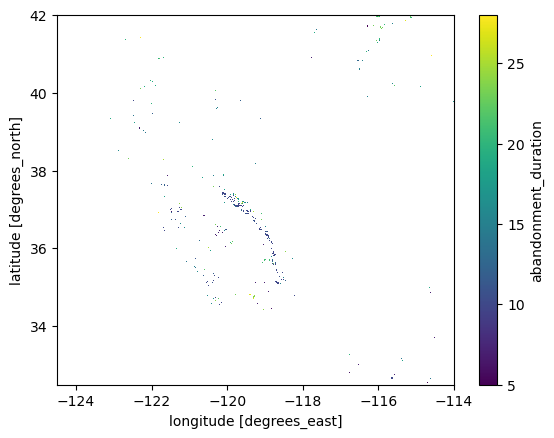

In [22]:
print(f"Number of non-NaN points: {np.count_nonzero(~np.isnan(rc_new['abandonment_duration']))}")
rc_new["abandonment_duration"].plot()


# Find first non-NaN point coordinates
valid_idx = np.where(~np.isnan(rc_new['abandonment_duration']))
example_i, example_j = valid_idx[0][0], valid_idx[1][0]

rc_new.isel(lat=example_i, lon=example_j)
rc["lccs_class"].isel(lat=example_i, lon=example_j).values


In [26]:
rc_new["abandonment_year"].isel(lat=example_i, lon=example_j)

<xarray.DataArray 'abandonment_year' ()> Size: 8B
array(8.836128e+17)
Coordinates:
    lat      float64 8B 42.0
    lon      float64 8B -116.1

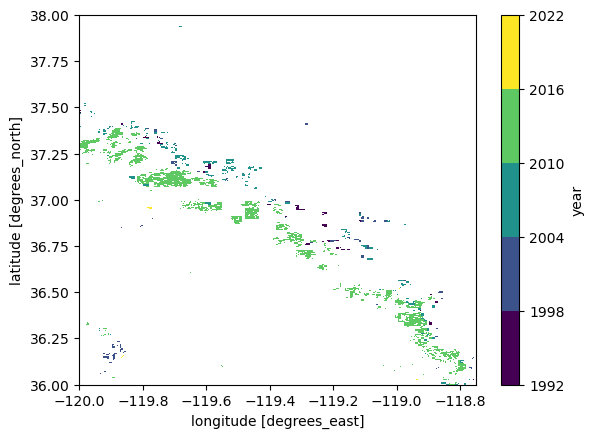

In [33]:
# Create 5 bins for years between 1992-2022
rc_new["abandonment_year"].astype('datetime64[ns]').dt.year.sel(lon=slice(-120,-118.75), lat=slice(38,36)).plot(
    cmap='viridis',
    levels=[1992, 1998, 2004, 2010, 2016, 2022]  # Split into 5 intervals
)



In [1]:
rc["lccs_class"].isel(time=1).sel(lon=slice(-120,-118.75), lat=slice(38,36)).where(rc["lccs_class"].isel(time=1) == 1).plot()

NameError: name 'rc' is not defined

# 将撂荒耕地重分配用于光伏发电及其减排效应评估

## Main Target:

观察在撂荒耕地再利用过程中太阳能光伏产生的碳效应权衡（结合有意思的观察修改故事线应当突出哪方面）

Highlight:

1. Introduce a spatial-temporal dynamic model to visualize the abatement potential of photovoltaic installation provided by abandonment cropland.

2. First attempt to measure the climate mitigation trade-offs in semi-agrivoltaics（非全完农业光伏，自己创造一个概念） along global abandoned cropland reallocation.

3. Though natural-based restroration strategy could be more cost-effective and work for climate change in the long-term, we emphasize development-based strategy could achieve co-benefits in a more expected way.


（主线逻辑：solar photovoltaic在《巴黎气候协定》中被认为是促进能源转型、实现气候目标的主要路径之一。然而，由于可再生能源功率密度比化石燃料低几个数量级，大规模进行太阳能光伏铺设需要占用大量土地资源，中国、美国等许多国家已经出现了剧烈土地竞争。在不同土地利用类型中，农田被认为是最有潜力也是最适宜进行太阳能光伏铺设的[[1]](https://www.nature.com/articles/s41598-019-47803-3)[[2]](https://iopscience.iop.org/article/10.1088/1748-9326/accc47/meta)，据测算，全球农业仅需要贡献1%面积即可满足全球能源需求。然而，最近研究表明，实际公共事业运行中光伏土地利用效率比理论估计低六倍，不仅如此，额外的生物多样性损失、水资源浪费、粮食产能损失也会导致其余可持续发展目标trade-off。除了采用农业光伏改良实现用途复合、采用钙钛矿电池等先进技术提升能量密度等直接降低土地竞争，研究农业空间显示优化策略更为cost-effective与重要。特别是随着撂荒成为全球农业土地利用的新现象，撂荒耕地再利用已经成为重要研究热点，但在撂荒耕地上实施半农业光伏改造的潜力被长期低估。

（光伏对于空间的要求...）由于撂荒耕地空间以避免直接与城镇化、保障粮食安全目标等相竞争，同时也能够满足太阳能光伏设备需要的地理环境因素。）

### 1、识别可用于太阳能光伏撂荒耕地时空演变特征
    Gap: 

    Research content: 
    1) **How much abandonment cropland could provide for solar photovoltaic installation in the future?**
    This 

    2) **Where the solar photovoltaic should be installed, to see if their is some model to quantify the suitability.**

    3) **Whether the abandonment land shoud be recultivated?

计算思路1：
构建一个二维策略博弈矩阵，生成单个像素的决策矩阵，但是需要把光伏期望收益与复垦期望效益进行比较（需要将2050收益贴现到当下时间节点）。其中，自然演化情景作为逼近纳什均衡一种可能（即忽视适宜性（成本）、都不接受，表示需要按照历史趋势，推演这些撂荒的extent会转化为什么【有可能是】）

    
### 2、农业光伏的理论减排效应核算
（故事逻辑：根据光伏测算理论上的碳效应）

    （需要进一步Literatue一下是否与第一部分有所重合）


### 3、农业光伏策略带来的机会性碳汇损失
（故事逻辑：将农业光伏策略与naturial-based strategy对比，观察在大规模森林植被恢复与自然演化趋势两种情景下固碳效应的变化趋势，测算农业光伏的机会性成本）

此时已经不再考虑适宜性，直接假设所有的光伏用地转化为森林植被恢复（林地）带来的碳汇效应

Background:
    use xarray open dataset as 'rc' 
    land cover refers to 'lccs_class'
    the year is from 1992 to 2022
    non-artificial land means valus is not equal to '1' or '7'
    cropland pixel value is 1

data: 
    1) ESA land use and land cover maps
    2) GLC_FCS30 land use and land cover maps 
    3) 
abandonment request:
    1）extract cropland mask to ；
    2）5 consecutive years remain non-artificial land 
    3）record the first year of abandonment and duration 

## Methods

### 1、cropland abandonment extent in 2022 the histroic duration

Given: use xarray, use tqdm, 'ds_ca' is xarray.Dataset (time:31,lat:3420,long:3780), which has variables 'lccs_class'. The value 1 is cropland. Let 非人工区域(non_artificial)为（not cropland (1) nor 7 (built-up).

Create a new dataset Output: 'rc_new' it has "abandonment_year", "abandonment_duration", "currently_abandonment" "historical_cultivation"variables.

create a mask, where:

1. at least 5 years of non-artificial land 
2. cropland exist 
3. starts with cropland and followed by 2 years non-artificial land 
4. starts with non-artificial land and followed by 4 years non-artificial

Then, use final mask to extract data from 'ds_ca'and perform abandonment calculation: 

for a sequence,
duration=0
current=false
abandonment_year=None
recultivation=false
    if a point is cropland:
        if abandonment_year is not none and duration>=5:
            recultivation=true
            save results
        else 
            abandonment_year = current year + 1
            duration=0
            move to next year 

    if a pixel in next year is non-artifical and abandonment_year is not none:
        duration+1

    if a pixel is built-up land and duration>=5:
        save results   

    if 遍历到了最后一个点2022年，并且 duration>=5
        current=true
        save results

### PV efficiency intergrated land suitability 

####1、Microclimate-informed PV efficiency model 

（1）光伏板能量平衡方程
$${\color{Orange}(1-\alpha-\varepsilon) R_{\downarrow}^{sun}+L_{\downarrow}^{sky}+L_{\uparrow}^{g}-2 L^{p}-2 q_{c o n v}=0,} $$

each parameter denotes as:
$\varepsilon$ denotes the efficiency of the solar panel（太阳能电池效率）；
$\alpha$ denotes PV panel surface albedo（光伏表面反射率）；$R_{\downarrow}^{sun}$ denotes shortwave radiation from the sun(短波辐射)
$L_{\downarrow}^{sky}$ refers to the integral longwave radiation reaching the solar module（长波辐射）；其余见Supplyment_materials


**Physiographic criterion**
- 全球太阳光伏板效率测算
- Slope: Smaller slopes facilitate construction and maintenance. (degree)
- Elevation: Lower elevations facilitate construction and maintenance. (m)

**Location criterion**
- Distance to settlements: Proximity to consumer markets. (m)
- Distance to roads: Reduces construction, transportation, and maintenance costs. (m)
- Distance to power lines: Avoids power losses and reduces connection costs. (m)

**Socioeconomic criterion**
- Gross Domestic Product (GDP): Reflects regional economic development level. Higher economic levels promote PV development. (10⁴ yuan/km²)
- Population: Reflects regional energy demand. (person/km²)
- Electricity consumption: Reflects regional energy consumption intensity. (10⁴ kWh/km²)

**Environmental criterion**
- Importance level for water retention: More ecologically important areas are less suitable for PV construction due to potential hydrological impacts.
- Importance level for soil retention: More ecologically important areas are less suitable due to potential soil structure impacts.
- Importance level for carbon sequestration: More ecologically important areas are less suitable due to potential vegetation damage.



## Use cali as example

#### (1) cropland abandonment detection

In [33]:
import xarray as xr
import numpy as np

# Suppose ds_ca is your Dataset with dims (time: 31, lat: 3420, long: 3780).
# lccs_class has integer-coded land-cover classes, where:
#   1 = cropland
#   7 = built-up
# (non_artificial means neither cropland nor built-up)

ds_ca=xr.open_dataset('output\ca_lccs.nc')
ds_ca
is_cropland = (ds_ca.lccs_class == 1)
is_builtup  = (ds_ca.lccs_class == 7)
is_non_artificial = ~(is_cropland | is_builtup) 

# C2:Count how many years each pixel is non-artificial; require >= 5
cond1 = (is_non_artificial.sum(dim='time') >= 5)
# C2:Check if at least one time-slice is cropland
cond2 = is_cropland.any(dim='time')


# C3: Check for any sequence where cropland is followed by 2 years of non-artificial land
cond3 = False
for t in range(len(ds_ca.time) - 2):
    cond3 = cond3 | (
        is_cropland.isel(time=t) 
        & is_non_artificial.isel(time=t+1) 
        & is_non_artificial.isel(time=t+2)
    )

# Fix the TypeError by ensuring all operands are boolean arrays
# Convert DataArrays to boolean type explicitly before performing bitwise operations
nonart_0 = is_non_artificial.astype(bool)
nonart_1 = is_non_artificial.shift(time=-1).fillna(False).astype(bool)
nonart_2 = is_non_artificial.shift(time=-2).fillna(False).astype(bool)
nonart_3 = is_non_artificial.shift(time=-3).fillna(False).astype(bool)
nonart_4 = is_non_artificial.shift(time=-4).fillna(False).astype(bool)

cond4 = (nonart_0 & nonart_1 & nonart_2 & nonart_3 & nonart_4).any(dim="time")

final_mask = cond1 & cond2 & cond3 & cond4





Text(0, 0.5, 'Latitude')

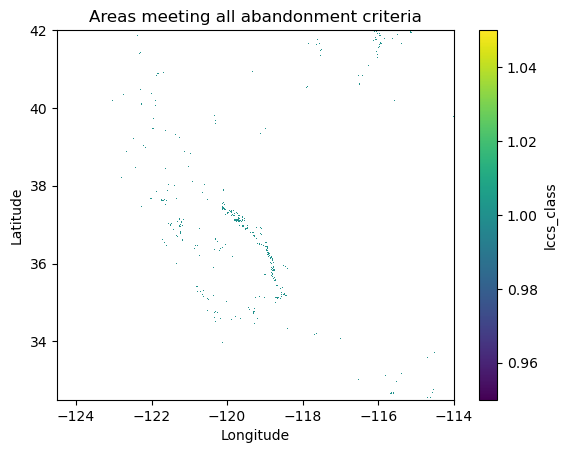

In [23]:
# Plot the final mask where it's True
import matplotlib.pyplot as plt
final_mask.where(final_mask).plot(cmap='viridis')
plt.title('Areas meeting all abandonment criteria')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Processing pixels:   0%|          | 0/31493 [00:00<?, ?it/s]

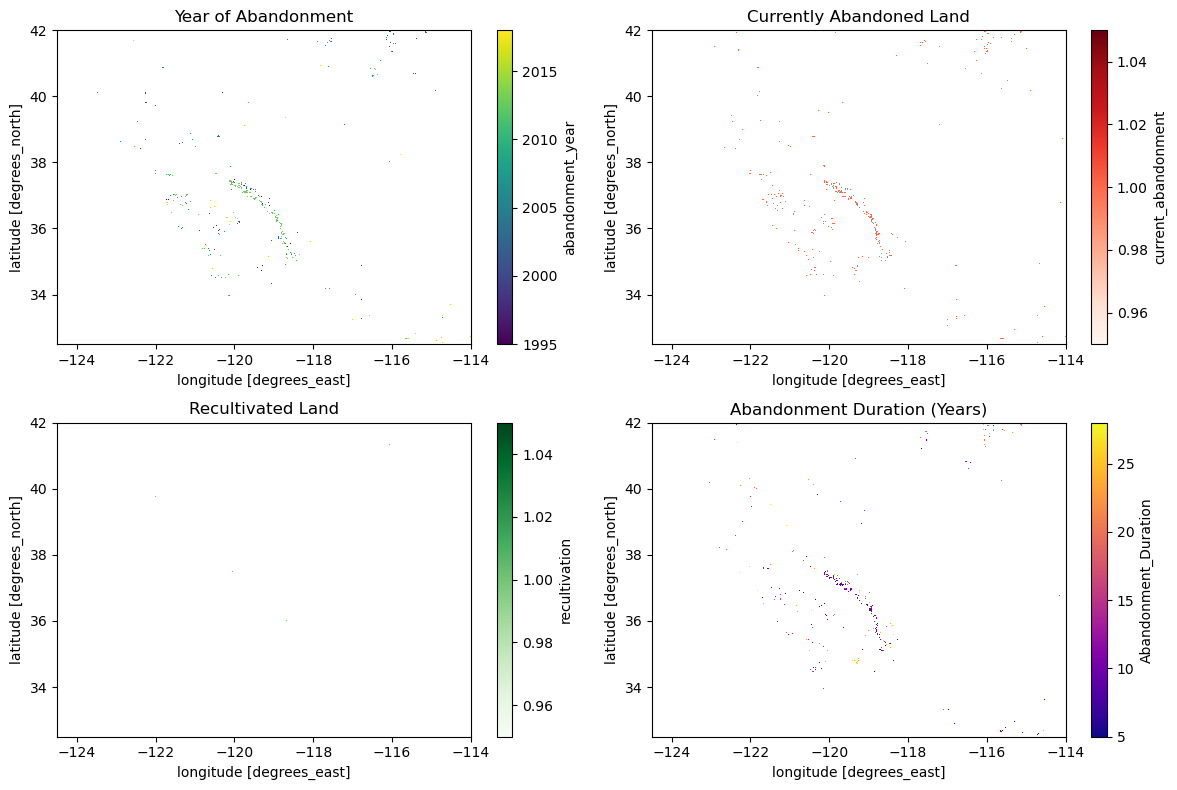

In [ ]:
# Implement the abandonment calculation algorithm
import numpy as np
import xarray as xr
from tqdm.notebook import tqdm
# Create arrays to store results
abandonment_year = np.full_like(ds_ca['lccs_class'].isel(time=0).values, np.nan, dtype=float)
abandonment_duration = np.full_like(ds_ca['lccs_class'].isel(time=0).values, np.nan, dtype=float)
recultivation = np.zeros_like(ds_ca['lccs_class'].isel(time=0).values, dtype=bool)
current_abandonment = np.zeros_like(ds_ca['lccs_class'].isel(time=0).values, dtype=bool)

# Get time values as years
years = ds_ca.time.dt.year.values

# Get indices of valid pixels using where
valid_indices = np.where(final_mask.values)



for i in tqdm(range(len(valid_indices[0])), desc="Processing pixels"):
    y, x = valid_indices[0][i], valid_indices[1][i]
    
    duration = 0
    abandonment_start = None
    
    # Process the time series for this pixel
    for t in range(len(years)):
        is_crop = is_cropland.isel(time=t).values[y, x]
        is_nonart = is_non_artificial.isel(time=t).values[y, x]
        
        if is_crop:
            # If previously abandoned for 5+ years, mark as recultivated
            if abandonment_start is not None and duration >= 5:
                recultivation[y, x] = True
                abandonment_year[y, x] = abandonment_start
                abandonment_duration[y, x] = duration
            # Reset tracking for cropland
            abandonment_start = None
            duration = 0
        elif is_nonart:
            # Start tracking abandonment if not already and previous year was cropland
            if abandonment_start is None and t > 0 and is_cropland.isel(time=t-1).values[y, x]:
                abandonment_start = years[t]
            
            # Increment duration if we're tracking abandonment
            if abandonment_start is not None:
                duration += 1
        else:
            # Reset if artificial land
            abandonment_start = None
            duration = 0
    
    # After processing all years, check if currently abandoned (2022)
    if abandonment_start is not None and duration >= 5:
        current_abandonment[y, x] = True
        abandonment_year[y, x] = abandonment_start
        abandonment_duration[y, x] = duration

# Convert results to DataArrays with the same coordinates as the input
abandonment_year_da = xr.DataArray(
    abandonment_year,
    coords=ds_ca['lccs_class'].isel(time=0).coords,
    dims=ds_ca['lccs_class'].isel(time=0).dims,
    name='abandonment_year'
)

recultivation_da = xr.DataArray(
    recultivation,
    coords=ds_ca['lccs_class'].isel(time=0).coords,
    dims=ds_ca['lccs_class'].isel(time=0).dims,
    name='recultivation'
)

current_abandonment_da = xr.DataArray(
    current_abandonment,
    coords=ds_ca['lccs_class'].isel(time=0).coords,
    dims=ds_ca['lccs_class'].isel(time=0).dims,
    name='current_abandonment'
)

abandonment_duration_da = xr.DataArray(
    abandonment_duration,
    coords=ds_ca['lccs_class'].isel(time=0).coords,
    dims=ds_ca['lccs_class'].isel(time=0).dims,
    name='Abandonment_Duration'
)

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
abandonment_year_da.where(~np.isnan(abandonment_year_da)).plot(cmap='viridis')
plt.title('Year of Abandonment')

plt.subplot(2, 2, 2)
current_abandonment_da.where(current_abandonment_da).plot(cmap='Reds')
plt.title('Currently Abandoned Land')

plt.subplot(2, 2, 3)
recultivation_da.where(recultivation_da).plot(cmap='Greens')
plt.title('Recultivated Land')

plt.subplot(2, 2, 4)
abandonment_duration_da.where(abandonment_duration_da > 0).plot(cmap='plasma')
plt.title('Abandonment Duration (Years)')

plt.tight_layout()

# Create new dataset with results




In [ ]:
# Create a new dataset with all the results
results_ca = xr.Dataset(
    data_vars={
        'current_abandonment': current_abandonment_da,
        'recultivation': recultivation_da,
        'abandonment_year': abandonment_year_da,
        'Abandonment_Duration':abandonment_duration_da
    }
)

# Export the dataset to a NetCDF file
output_file = 'output\california_cropland_abandonment_results.nc'
results_ca.to_netcdf(output_file)
print(f"Results exported to {output_file}")

# Display the dataset
results_ca

Results exported to output\california_cropland_abandonment_results.nc


<xarray.Dataset> Size: 233MB
Dimensions:               (lat: 3420, lon: 3780)
Coordinates:
  * lat                   (lat) float64 27kB 42.0 42.0 41.99 ... 32.51 32.5 32.5
  * lon                   (lon) float64 30kB -124.5 -124.5 ... -114.0 -114.0
    time                  datetime64[ns] 8B 1992-01-01
Data variables:
    current_abandonment   (lat, lon) bool 13MB False False False ... False False
    recultivation         (lat, lon) bool 13MB False False False ... False False
    abandonment_year      (lat, lon) float64 103MB nan nan nan ... nan nan nan
    Abandonment_Duration  (lat, lon) float64 103MB nan nan nan ... nan nan nan

In [ ]:
# Find coordinates where recultivation is True
recultivation_coords = np.where(results_ca['recultivation'].values)
if len(recultivation_coords[0]) > 0:
    # Get the first coordinate where recultivation is True
    first_idx = 0
    lat_idx, lon_idx = recultivation_coords[0][first_idx], recultivation_coords[1][first_idx]
    
    # Get the actual lat/lon values
    lat_value = results_ca.lat.values[lat_idx]
    lon_value = results_ca.lon.values[lon_idx]
    
    print(f"Recultivation is True at coordinate: lat={lat_value}, lon={lon_value}")
    
    # Verify the value at this coordinate
    point = results_ca['recultivation'].sel(lat=lat_value, lon=lon_value, method='nearest')
    print(f"Recultivation value at this point: {point.values}")
else:
    print("No coordinates found where recultivation is True")


Recultivation is True at coordinate: lat=41.90694444444446, lon=-115.0736111111111
Recultivation value at this point: True


Land cover class sequence at lat=41.90694444444446, lon=-115.0736111111111:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 1. 1. 1. 1.]


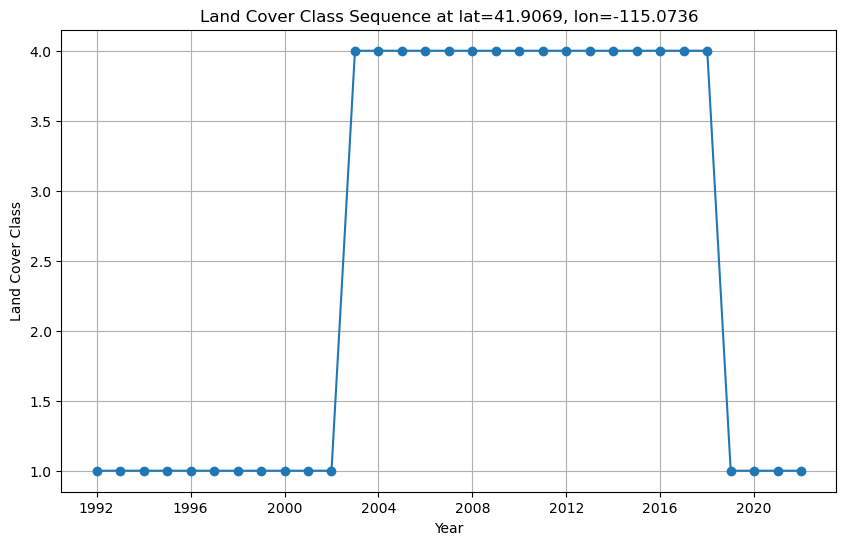

Abandonment year: 2003.0
Abandonment duration: 16.0


In [ ]:
# Get the sequence of land cover classes for the example coordinate
if 'lat_value' in locals() and 'lon_value' in locals():
    # Extract the time series of land cover classes at this location
    time_series = ds_ca['lccs_class'].sel(lat=lat_value, lon=lon_value, method='nearest')
    
    print(f"Land cover class sequence at lat={lat_value}, lon={lon_value}:")
    print(time_series.values)
    
    # Visualize the time series
    plt.figure(figsize=(10, 6))
    plt.plot(time_series.time.values, time_series.values, 'o-')
    plt.title(f'Land Cover Class Sequence at lat={lat_value:.4f}, lon={lon_value:.4f}')
    plt.xlabel('Year')
    plt.ylabel('Land Cover Class')
    plt.grid(True)
    plt.show()
    
    # Show abandonment and recultivation information for this point
    print(f"Abandonment year: {results_ca['abandonment_year'].sel(lat=lat_value, lon=lon_value, method='nearest').values}")
    print(f"Abandonment duration: {results_ca['Abandonment_Duration'].sel(lat=lat_value, lon=lon_value, method='nearest').values}")
else:
    print("No example coordinates available")






#### (2) Microclimate-informed PV efficiency model 



In [2]:
import xarray as xr

ds_ca=xr.open_dataset('output\ca_lccs.nc',engine='netcdf4')
ds_ca

# Print the range of latitude and longitude in the dataset
print("Latitude range:")
print(f"Min: {ds_ca.lat.min().values}, Max: {ds_ca.lat.max().values}")
print(f"Number of latitude points: {len(ds_ca.lat)}")

print("\nLongitude range:")
print(f"Min: {ds_ca.lon.min().values}, Max: {ds_ca.lon.max().values}")
print(f"Number of longitude points: {len(ds_ca.lon)}")

# Calculate the resolution
if len(ds_ca.lat) > 1:
    lat_resolution = abs(ds_ca.lat[1].values - ds_ca.lat[0].values)
    print(f"\nLatitude resolution: {lat_resolution:.6f} degrees")

if len(ds_ca.lon) > 1:
    lon_resolution = abs(ds_ca.lon[1].values - ds_ca.lon[0].values)
    print(f"Longitude resolution: {lon_resolution:.6f} degrees")


Latitude range:
Min: 32.5013888888889, Max: 41.9986111111111
Number of latitude points: 3420

Longitude range:
Min: -124.4986111111111, Max: -114.00138888888888
Number of longitude points: 3780

Latitude resolution: 0.002778 degrees
Longitude resolution: 0.002778 degrees


##### 1、DEM 

Adding n30w110.tif to mosaic
Adding n30w115.tif to mosaic
Adding n30w120.tif to mosaic
Adding n30w125.tif to mosaic
Adding n35w110.tif to mosaic
Adding n35w115.tif to mosaic
Adding n35w120.tif to mosaic
Adding n35w125.tif to mosaic
Adding n40w110.tif to mosaic
Adding n40w115.tif to mosaic
Adding n40w120.tif to mosaic
Adding n40w125.tif to mosaic


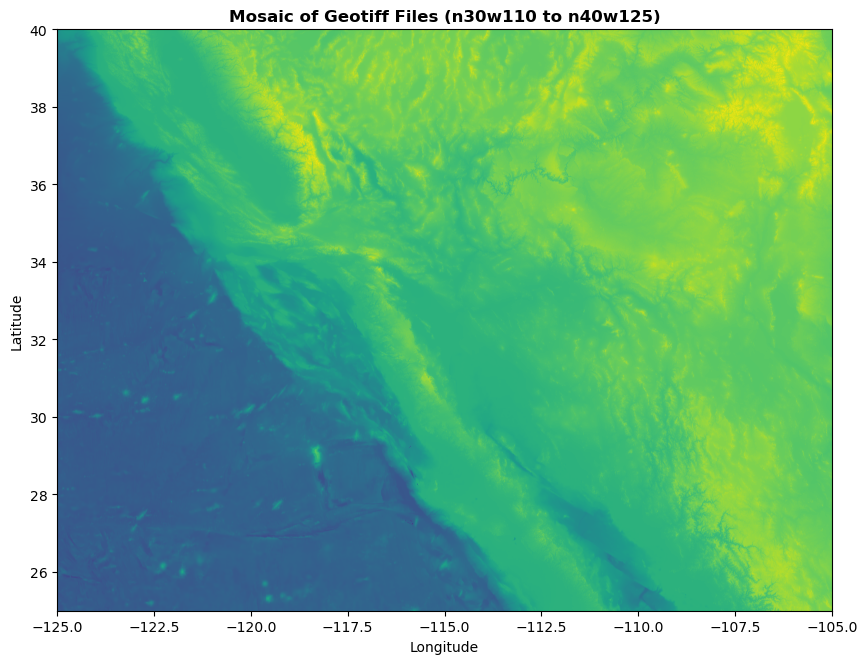

Mosaic created successfully at output/cali_dem_mosaic.tif
Mosaic shape: (18001, 24001)
Mosaic bounds: BoundingBox(left=-125.00000022, bottom=24.99916692667, right=-104.99916696667, top=40.0000002)


In [ ]:
import os
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

lat_range = range(30, 45, 5)  # n30, n35, n40
lon_range = range(110, 130, 5)  # w110, w115, w120, w125

# Function to create the mosaic
def create_mosaic(lat_range, lon_range, output_path='output/cali_dem_mosaic.tif'):
    # List to store opened datasets
    src_files_to_mosaic = []
    
    # Open each input file
    for lat in lat_range:
        for lon in lon_range:
            filename = f"n{lat}w{lon}.tif"
            filepath = Path('data') / filename
            
            if filepath.exists():
                print(f"Adding {filename} to mosaic")
                src = rasterio.open(filepath)
                src_files_to_mosaic.append(src)
            else:
                print(f"Warning: {filename} not found, skipping")
    
    if not src_files_to_mosaic:
        print("No input files found. Check file paths and naming convention.")
        return None
    
    # Merge the datasets
    mosaic, out_trans = merge(src_files_to_mosaic)
    
    # Copy the metadata from the first input file
    out_meta = src_files_to_mosaic[0].meta.copy()
    
    # Update the metadata
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
    })
    
    # Write the mosaic to disk
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(mosaic)
    
    # Close the input files
    for src in src_files_to_mosaic:
        src.close()
    
    return output_path

# Create the mosaic
mosaic_path = create_mosaic(lat_range, lon_range)

# Visualize the result if successful
if mosaic_path and os.path.exists(mosaic_path):
    with rasterio.open(mosaic_path) as src:
        fig, ax = plt.subplots(figsize=(10, 8))
        show(src, ax=ax, title="Mosaic of Geotiff Files (n30w110 to n40w125)")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()
        
        print(f"Mosaic created successfully at {mosaic_path}")
        print(f"Mosaic shape: {src.shape}")
        print(f"Mosaic bounds: {src.bounds}")
else:
    print("Failed to create mosaic")



##### 2、extract climate variables

In [6]:
import xarray as xr
import numpy as np
import pandas as pd
import dask  # optional, if your data is large
from scipy.optimize import root   # or fsolve, newton, etc.

fn_tair = "daily_airtemp.nc"
fn_wind = "daily_windspeed.nc"
fn_srad = "daily_shortwave.nc"
fn_vp   = "daily_vaporpressure.nc"

ds_t = xr.open_dataset(fn_tair)  # Suppose var name is 'tair'
ds_u = xr.open_dataset(fn_wind)  # Suppose var name is 'wind'
ds_r = xr.open_dataset(fn_srad)  # Suppose var name is 'srad'
ds_e = xr.open_dataset(fn_vp)    # Suppose var name is 'ea'

# Merge them into a single xarray Dataset
# Here, we rename the data variables so they match "Tair","Wind","SWRad","ea" for clarity
ds_all = xr.merge([
    ds_t.rename_vars({"tair":"Tair"}),
    ds_u.rename_vars({"wind":"Wind"}),
    ds_r.rename_vars({"srad":"SWRad"}),
    ds_e.rename_vars({"ea":"ea"})
])

Example panel efficiency calculation:
<xarray.DataArray 'panel_eff' (time: 3, lat: 3, lon: 3)> Size: 216B
array([[[11.1844791 , 11.19167752, 11.11015423],
        [11.14528676, 11.4008434 , 11.1030757 ],
        [11.28676367, 11.41726377, 11.30934343]],

       [[11.25564788, 11.36775455, 11.32338241],
        [11.29564062, 11.18978832, 11.4575134 ],
        [11.21184969, 11.14132795, 11.1257369 ]],

       [[11.2312488 , 11.29487641, 11.44360703],
        [11.32504939, 11.26631683, 11.34557551],
        [11.11675439, 11.12272249, 11.33265567]]])
Coordinates:
  * time     (time) datetime64[ns] 24B 2022-01-01 2022-01-02 2022-01-03
  * lat      (lat) float64 24B 35.0 35.5 36.0
  * lon      (lon) float64 24B -120.0 -119.5 -119.0


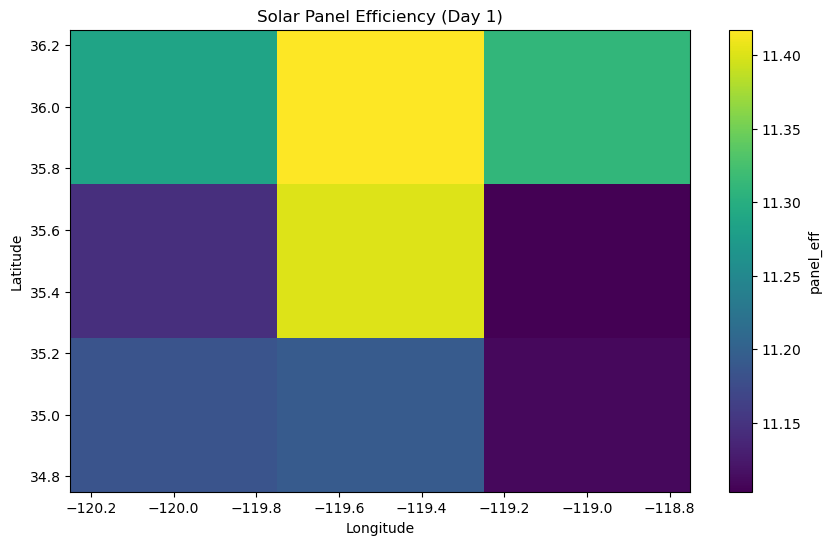

In [9]:
import math

# Physical constants
sigma = 5.670374419e-8  # Stefan-Boltzmann [W m^-2 K^-4]
k_air = 0.026           # thermal conductivity of air ~ [W m^-1 K^-1]
nu    = 1.57e-5         # kinematic viscosity of air [m^2 s^-1]
Pr    = 0.707           # Prandtl number of air (approx)
l_panel = 1.5           # characteristic panel length [m], from the paper
alpha = 0.2             # panel shortwave albedo
Tref  = 298.0           # reference T for linear eff. eqn (K)
eps_ref = 0.135         # reference panel efficiency
A_coeff = 0.0051        # linear slope [1/K] for efficiency drop from Tref


def longwave_sky(Ta, ea_hPa):
    """
    Brutsaert (1975) parameterization:
        L_sky_down = sigma * (ea / Ta^(1/7)) * Ta^4
    `Ta` in Kelvin, `ea` in hPa
    """
    # If ea is in hPa, this is consistent with the paper's approach.
    # If your data is in Pa, you'd convert first: ea(hPa) = ea(Pa)/100.
    return 1.24 * sigma * ((ea_hPa / Ta)**(1/7)) * (Ta**4)

def longwave_ground(Tg):
    # blackbody from ground
    return  Tg**4

def longwave_panel(Tp):
    # blackbody from panel
    return sigma * (Tp**4)


def h_conv_coeff(u):
    """
    Convective heat transfer coefficient h.
    h = 0.036 * (k_air / l_panel) * (u*l_panel / nu)^(4/5)* Pr^(1/3)
    """
    Re_panel = (u*l_panel)/nu
    return 0.036 * (k_air / l_panel) * (Re_panel**(4/5)) * (Pr**(1/3))

def panel_efficiency(Tp):
    """
    Linear drop in efficiency from reference:
       eps = eps_ref * [ 1 - A_coeff*(Tp - Tref) ]
    valid if (Tp - Tref) is not too large
    """
    return eps_ref * (1 - A_coeff*(Tp - Tref))

def panel_temp_resid(Tp, Rsun, Ta, u, ea_hPa):
    """
    Residual of the net energy flux = 0:
      (1 - alpha - eps)*Rsun + L_down_sky + L_up_ground
         - 2*L_panel - 2*h*(Tp - Ta) = 0
    where eps depends on Tp.
    """
    h  = h_conv_coeff(u)
    Ls = longwave_sky(Ta, ea_hPa)
    Lg = longwave_ground(Ta)
    Lp = longwave_panel(Tp)
    eps = panel_efficiency(Tp)
    
    return ((1 - alpha)*Rsun - eps*Rsun
            + Ls + Lg
            - 2*Lp
            - 2*h*(Tp - Ta))

def solve_panel_eff(Rsun, Ta, U, ea_hPa):
    # Initial guess: panel is a bit hotter than air
    T_guess = float(Ta) + 5.0
    sol = root(panel_temp_resid, T_guess, args=(Rsun, Ta, U, ea_hPa))
    if sol.success:
        Tp_sol = sol.x[0]
        return panel_efficiency(Tp_sol)
    else:
        return np.nan
    
def compute_efficiency(ds):
    return xr.apply_ufunc(
        solve_panel_eff,
        ds['SWRad'], ds['Tair'], ds['Wind'], ds['ea'],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float]
    ).rename("panel_eff")

# Example dataset with sample values
# Create a small example dataset with realistic values
times = pd.date_range('2022-01-01', periods=3, freq='D')
lats = np.linspace(35, 36, 3)
lons = np.linspace(-120, -119, 3)

# Sample climate data
example_data = xr.Dataset(
    data_vars={
        'Tair': (('time', 'lat', 'lon'), 273.15 + np.random.uniform(15, 25, size=(3, 3, 3))),  # K
        'Wind': (('time', 'lat', 'lon'), np.random.uniform(1, 5, size=(3, 3, 3))),             # m/s
        'SWRad': (('time', 'lat', 'lon'), np.random.uniform(1.4e7, 1.6e7, size=(3, 3, 3))),    # W/m² (around 1.5*1e7)
        'ea': (('time', 'lat', 'lon'), np.random.uniform(10, 20, size=(3, 3, 3)))              # hPa
    },
    coords={
        'time': times,
        'lat': lats,
        'lon': lons
    }
)

# Compute panel efficiency for the example data
example_efficiency = compute_efficiency(example_data)
print("Example panel efficiency calculation:")
print(example_efficiency)

# Visualize the results for one time step
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
example_efficiency.isel(time=0).plot()
plt.title('Solar Panel Efficiency (Day 1)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:

# Define paths to climate data files
# Variable names are : Temperature_Air_2m_Mean_Day_Time, Vapour_Pressure_Mean, Wind_Speed_10m_Mean,Solar_Radiation_Flux

tem_path=r'C:\Users\zpy10\OneDrive\Databackup\Agrometeorological indicators\air2m_temperature\Temperature-Air-2m-Mean-24h_C3S-glob-agric_AgERA5_20221114_final-v1.1.nc'
vapor_path=r'C:\Users\zpy10\OneDrive\Databackup\Agrometeorological indicators\Vapor_pressure\Vapour-Pressure-Mean_C3S-glob-agric_AgERA5_20221114_final-v1.1.nc'
wind_path=r'C:\Users\zpy10\OneDrive\Databackup\Agrometeorological indicators\Wind_speed\Wind-Speed-10m-Mean_C3S-glob-agric_AgERA5_20221124_final-v1.1.nc'
solar_path=r'C:\Users\zpy10\OneDrive\Databackup\Agrometeorological indicators\Sun_shortradiation\Solar-Radiation-Flux_C3S-glob-agric_AgERA5_20221124_final-v1.1.nc'
tem_day_path=r'C:\Users\zpy10\OneDrive\Databackup\Agrometeorological indicators\air2m_temperature\Temperature-Air-2m-Mean-Day-Time_C3S-glob-agric_AgERA5_20221114_final-v1.1.nc'

# Open climate datasets with xarray
ds_temp = xr.open_dataset(tem_path)
ds_vapor = xr.open_dataset(vapor_path)
ds_wind = xr.open_dataset(wind_path)
ds_solar = xr.open_dataset(solar_path)
ds_day = xr.open_dataset(tem_day_path)

# Define USA bounding box (approximate)
usa_bounds = {
    'lat': slice(25, 50),  # Roughly covers continental US
    'lon': slice(-125, -65)  # Roughly covers continental US
}

# Sample 1000 random points within USA for each dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import random

# Get USA region data
ds_temp_usa = ds_temp.sel(lat=usa_bounds['lat'], lon=usa_bounds['lon'])
ds_vapor_usa = ds_vapor.sel(lat=usa_bounds['lat'], lon=usa_bounds['lon'])
ds_wind_usa = ds_wind.sel(lat=usa_bounds['lat'], lon=usa_bounds['lon'])
ds_solar_usa = ds_solar.sel(lat=usa_bounds['lat'], lon=usa_bounds['lon'])
ds_day_usa = ds_day.sel(lat=usa_bounds['lat'], lon=usa_bounds['lon'])

# Get all valid lat/lon coordinates
lats = ds_temp_usa.lat.values
lons = ds_temp_usa.lon.values

# Generate 1000 random indices for sampling
num_samples = 1000
lat_indices = np.random.choice(len(lats), num_samples)
lon_indices = np.random.choice(len(lons), num_samples)

# Create sample points
sample_lats = lats[lat_indices]
sample_lons = lons[lon_indices]

# Create a figure with subplots for visualization
plt.figure(figsize=(20, 15))
gs = GridSpec(3, 2, figure=plt.gcf())

# Plot Temperature data
ax1 = plt.subplot(gs[0, 0])
temp_var = list(ds_temp_usa.data_vars)[0]  # Get the first variable name
temp_data = ds_temp_usa[temp_var].isel(time=0)
temp_data.plot(ax=ax1, cmap='coolwarm')
ax1.scatter(sample_lons, sample_lats, color='black', s=1, alpha=0.5)
ax1.set_title('Temperature (K)')

# Plot Vapor Pressure data
ax2 = plt.subplot(gs[0, 1])
vapor_var = list(ds_vapor_usa.data_vars)[0]
vapor_data = ds_vapor_usa[vapor_var].isel(time=0)
vapor_data.plot(ax=ax2, cmap='Blues')
ax2.scatter(sample_lons, sample_lats, color='black', s=1, alpha=0.5)
ax2.set_title('Vapor Pressure (hPa)')

# Plot Wind Speed data
ax3 = plt.subplot(gs[1, 0])
wind_var = list(ds_wind_usa.data_vars)[0]
wind_data = ds_wind_usa[wind_var].isel(time=0)
wind_data.plot(ax=ax3, cmap='YlGnBu')
ax3.scatter(sample_lons, sample_lats, color='black', s=1, alpha=0.5)
ax3.set_title('Wind Speed (m/s)')

# Plot Solar Radiation data
ax4 = plt.subplot(gs[1, 1])
solar_var = list(ds_solar_usa.data_vars)[0]
solar_data = ds_solar_usa[solar_var].isel(time=0)
solar_data.plot(ax=ax4, cmap='YlOrRd')
ax4.scatter(sample_lons, sample_lats, color='black', s=1, alpha=0.5)
ax4.set_title('Solar Radiation (W/m²)')

# Plot Day Temperature data
ax5 = plt.subplot(gs[2, 0])
day_var = list(ds_day_usa.data_vars)[0]
day_data = ds_day_usa[day_var].isel(time=0)
day_data.plot(ax=ax5, cmap='coolwarm')
ax5.scatter(sample_lons, sample_lats, color='black', s=1, alpha=0.5)
ax5.set_title('Day Temperature (K)')

# Extract sample values for each dataset
sample_points = []
for i in range(num_samples):
    lat, lon = sample_lats[i], sample_lons[i]
    point_data = {
        'lat': lat,
        'lon': lon,
        'temperature': float(temp_data.sel(lat=lat, lon=lon, method='nearest')),
        'vapor_pressure': float(vapor_data.sel(lat=lat, lon=lon, method='nearest')),
        'wind_speed': float(wind_data.sel(lat=lat, lon=lon, method='nearest')),
        'solar_radiation': float(solar_data.sel(lat=lat, lon=lon, method='nearest')),
        'day_temperature': float(day_data.sel(lat=lat, lon=lon, method='nearest'))
    }
    sample_points.append(point_data)

# Display summary statistics of sampled points
import pandas as pd
df_samples = pd.DataFrame(sample_points)
summary_stats = df_samples.describe()

# Plot histogram of sampled values
ax6 = plt.subplot(gs[2, 1])
for col, color in zip(['temperature', 'vapor_pressure', 'wind_speed', 'solar_radiation', 'day_temperature'], 
                      ['red', 'blue', 'green', 'orange', 'purple']):
    normalized_values = (df_samples[col] - df_samples[col].min()) / (df_samples[col].max() - df_samples[col].min())
    ax6.hist(normalized_values, alpha=0.3, color=color, label=col)
ax6.set_title('Normalized Distribution of Sampled Values')
ax6.legend()

plt.tight_layout()
plt.show()

print(f"Sampled {num_samples} points from USA region")
print("Summary statistics of sampled points:")
display(summary_stats)


SyntaxError: invalid syntax (3436545476.py, line 1)

### Perform globally

In [ ]:
import numpy as np
import xarray as xr
from tqdm.notebook import tqdm

# Try opening with explicit engine specification
ds_glb = xr.open_dataset('output/recalss_lccs.nc', engine='netcdf4')

ds_glb

# Process in chunks to avoid memory issues
chunk_size = 1000  # Adjust based on available memory
lat_chunks = range(0, len(ds_glb.lat), chunk_size)
lon_chunks = range(0, len(ds_glb.lon), chunk_size)

# Create an empty dataset to store the final mask
final_mask_ds = xr.Dataset(
    data_vars={
        'final_mask': (('lat', 'lon'), np.zeros((len(ds_glb.lat), len(ds_glb.lon)), dtype=bool))
    },
    coords={
        'lat': ds_glb.lat,
        'lon': ds_glb.lon
    }
)

# Process data in chunks
for lat_start in tqdm(lat_chunks, desc="Processing latitude chunks"):
    lat_end = min(lat_start + chunk_size, len(ds_glb.lat))
    
    for lon_start in tqdm(lon_chunks, desc=f"Processing longitude chunks for lat {lat_start}-{lat_end}", leave=False):
        lon_end = min(lon_start + chunk_size, len(ds_glb.lon))
        
        # Load chunk into memory
        chunk = ds_glb.isel(lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end))
        
        # Calculate conditions for this chunk
        is_cropland = (chunk.lccs_class == 1)
        is_builtup = (chunk.lccs_class == 7)
        is_non_artificial = ~(is_cropland | is_builtup)
        
        # C1: Count how many years each pixel is non-artificial; require >= 5
        cond1 = (is_non_artificial.sum(dim='time') >= 5)
        
        # C2: Check if at least one time-slice is cropland
        cond2 = is_cropland.any(dim='time')
        
        # C3: Check for any sequence where cropland is followed by 2 years of non-artificial land
        cond3 = xr.zeros_like(cond1)
        for t in range(len(chunk.time) - 2):
            crop_t = is_cropland.isel(time=t)
            nonart_t1 = is_non_artificial.isel(time=t+1)
            nonart_t2 = is_non_artificial.isel(time=t+2)
            cond3 = cond3 | (crop_t & nonart_t1 & nonart_t2)
        
        # C4: Check for 5 consecutive years of non-artificial land
        cond4 = xr.zeros_like(cond1)
        for t in range(len(chunk.time) - 4):
            consecutive_nonart = (
                is_non_artificial.isel(time=t) &
                is_non_artificial.isel(time=t+1) &
                is_non_artificial.isel(time=t+2) &
                is_non_artificial.isel(time=t+3) &
                is_non_artificial.isel(time=t+4)
            )
            cond4 = cond4 | consecutive_nonart
        
        # Combine all conditions
        chunk_mask = cond1 & cond2 & cond3 & cond4
        
        # Update the final mask with this chunk's results
        final_mask_ds['final_mask'].loc[dict(
            lat=slice(chunk.lat[0].item(), chunk.lat[-1].item()),
            lon=slice(chunk.lon[0].item(), chunk.lon[-1].item())
        )] = chunk_mask.values
        
        # Clear memory
        del chunk, is_cropland, is_builtup, is_non_artificial, cond1, cond2, cond3, cond4, chunk_mask

final_mask_ds.to_netcdf('final_mask.nc')
print("Final mask saved to 'final_mask.nc'")


Mask dimensions: FrozenMappingWarningOnValuesAccess({'lat': 64800, 'lon': 129600})


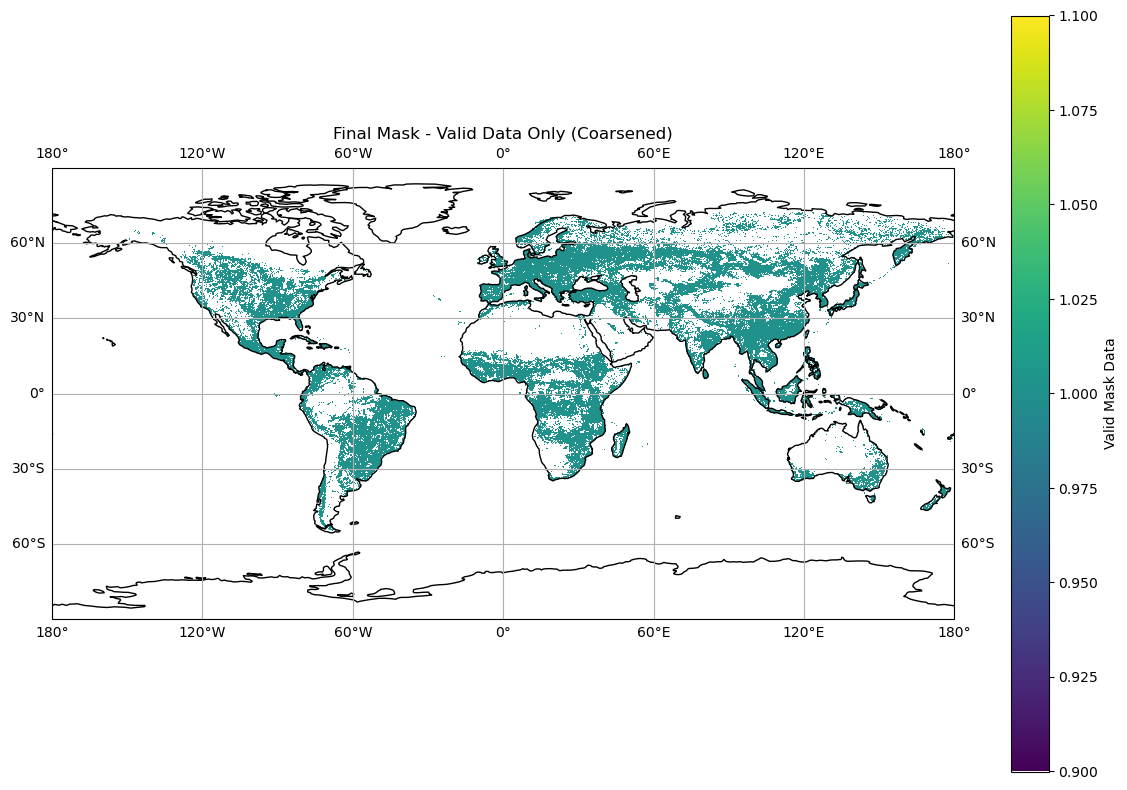

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr

mask_ds = xr.open_dataset('output/final_mask.nc')

# Plot the final mask with a coarser resolution due to large dimensions
print(f"Mask dimensions: {mask_ds.dims}")

coarsen_factor = 100

# Coarsen the mask by taking the mean over blocks
coarse_mask = mask_ds.coarsen(lat=coarsen_factor, lon=coarsen_factor, boundary='trim').mean()

# Convert to boolean or numeric type before applying inversion
# This fixes the TypeError with the invert (~) operation
mask_values = coarse_mask.final_mask.values.astype(bool)

# Create a masked array where invalid data (False values) are masked
masked_data = np.ma.masked_where(~mask_values, mask_values)

# Plot only the valid data
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Use pcolormesh to plot only valid data
im = ax.pcolormesh(coarse_mask.lon, coarse_mask.lat, masked_data, 
                  transform=ccrs.PlateCarree(),
                  cmap='viridis')

# Add a colorbar
plt.colorbar(im, ax=ax, label='Valid Mask Data')

# Add coastlines and gridlines for reference
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('Final Mask - Valid Data Only (Coarsened)')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import xarray as xr
from tqdm.notebook import tqdm
import gc
import os
import dask.array as da

# Load the final mask from the saved file
final_mask_ds = xr.open_dataset('output/final_mask.nc')
final_mask = final_mask_ds['final_mask']

# Load the global dataset with chunking to avoid memory issues
ds_glb = xr.open_dataset('output/recalss_lccs.nc', chunks={'time': 1, 'lat': 500, 'lon': 500})

# Get time values as years
years = ds_glb.time.dt.year.values

# Process in smaller chunks to avoid memory issues
chunk_size_lat = 500
chunk_size_lon = 500
lat_chunks = range(0, ds_glb.sizes['lat'], chunk_size_lat)
lon_chunks = range(0, ds_glb.sizes['lon'], chunk_size_lon)

# Create output file path
output_file = 'output/abandonment_analysis.nc'

# Get dimensions
lat_size = ds_glb.sizes['lat']
lon_size = ds_glb.sizes['lon']

# Instead of creating large arrays in memory, create dask arrays
# This avoids the MemoryError when allocating large arrays
abandonment_year = da.full((lat_size, lon_size), np.nan, dtype=np.float32)  # Using float32 instead of float64
abandonment_duration = da.full((lat_size, lon_size), np.nan, dtype=np.float32)  # Using float32 instead of float64
recultivation = da.zeros((lat_size, lon_size), dtype=bool)
current_abandonment = da.zeros((lat_size, lon_size), dtype=bool)

# Get the indices of valid data from final_mask
valid_mask = final_mask.compute()
valid_indices = np.where(valid_mask.values)
valid_pixels = list(zip(valid_indices[0], valid_indices[1]))

# Group valid pixels by chunks to process them efficiently
chunk_pixel_map = {}
for y, x in valid_pixels:
    lat_chunk = y // chunk_size_lat
    lon_chunk = x // chunk_size_lon
    chunk_key = (lat_chunk, lon_chunk)
    
    if chunk_key not in chunk_pixel_map:
        chunk_pixel_map[chunk_key] = []
    
    # Store local coordinates within the chunk
    chunk_pixel_map[chunk_key].append((y % chunk_size_lat, x % chunk_size_lon, y, x))

# Create temporary arrays for each chunk to avoid memory issues
for chunk_key in tqdm(chunk_pixel_map.keys(), desc="Processing chunks with valid data"):
    lat_chunk, lon_chunk = chunk_key
    lat_start = lat_chunk * chunk_size_lat
    lon_start = lon_chunk * chunk_size_lon
    lat_end = min(lat_start + chunk_size_lat, ds_glb.sizes['lat'])
    lon_end = min(lon_start + chunk_size_lon, ds_glb.sizes['lon'])
    
    # Extract chunk
    chunk = ds_glb.isel(lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end))
    
    # Load the chunk data into memory
    chunk = chunk.compute()
    
    # Create temporary arrays for this chunk
    chunk_abandonment_year = np.full((lat_end - lat_start, lon_end - lon_start), np.nan, dtype=np.float32)
    chunk_abandonment_duration = np.full((lat_end - lat_start, lon_end - lon_start), np.nan, dtype=np.float32)
    chunk_recultivation = np.zeros((lat_end - lat_start, lon_end - lon_start), dtype=bool)
    chunk_current_abandonment = np.zeros((lat_end - lat_start, lon_end - lon_start), dtype=bool)
    
    # Pre-compute land cover classifications for the chunk
    is_cropland = (chunk.lccs_class == 1)
    is_builtup = (chunk.lccs_class == 7)
    is_non_artificial = ~(is_cropland | is_builtup)
    
    # Process only valid pixels in this chunk
    for local_y, local_x, global_y, global_x in chunk_pixel_map[chunk_key]:
        duration = 0
        abandonment_start = None
        
        # Process the time series for this pixel
        for t in range(len(years)):
            is_crop = is_cropland.isel(time=t).values[local_y, local_x]
            is_nonart = is_non_artificial.isel(time=t).values[local_y, local_x]
            
            if is_crop:
                # If previously abandoned for 5+ years, mark as recultivated
                if abandonment_start is not None and duration >= 5:
                    chunk_recultivation[local_y, local_x] = True
                    chunk_abandonment_year[local_y, local_x] = abandonment_start
                    chunk_abandonment_duration[local_y, local_x] = duration
                # Reset tracking for cropland
                abandonment_start = None
                duration = 0
            elif is_nonart:
                # Start tracking abandonment if not already and previous year was cropland
                if abandonment_start is None and t > 0 and is_cropland.isel(time=t-1).values[local_y, local_x]:
                    abandonment_start = years[t]
                
                # Increment duration if we're tracking abandonment
                if abandonment_start is not None:
                    duration += 1
            else:
                # Reset if artificial land
                abandonment_start = None
                duration = 0
        
        # After processing all years, check if currently abandoned (2022)
        if abandonment_start is not None and duration >= 5:
            chunk_current_abandonment[local_y, local_x] = True
            chunk_abandonment_year[local_y, local_x] = abandonment_start
            chunk_abandonment_duration[local_y, local_x] = duration
    
    # Create a temporary dataset for this chunk
    chunk_ds = xr.Dataset(
        data_vars={
            'abandonment_year': (('lat', 'lon'), chunk_abandonment_year),
            'Abandonment_Duration': (('lat', 'lon'), chunk_abandonment_duration),
            'recultivation': (('lat', 'lon'), chunk_recultivation),
            'current_abandonment': (('lat', 'lon'), chunk_current_abandonment)
        },
        coords={
            'lat': chunk.lat,
            'lon': chunk.lon
        }
    )
    
    # Save this chunk to a temporary file
    temp_file = f'output/temp_chunk_{lat_chunk}_{lon_chunk}.nc'
    chunk_ds.to_netcdf(temp_file)
    
    # Clear memory
    del chunk, is_cropland, is_builtup, is_non_artificial
    del chunk_abandonment_year, chunk_abandonment_duration, chunk_recultivation, chunk_current_abandonment
    del chunk_ds
    gc.collect()


c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Processing chunks with valid data:   0%|          | 0/6488 [00:00<?, ?it/s]

Combining chunks into final dataset...


Merging chunks:   0%|          | 0/6488 [00:00<?, ?it/s]

NotImplementedError: xarray can't set arrays with multiple array indices to dask yet.

In [2]:
import xarray as xr
ds_glb = xr.open_dataset('output/recalss_lccs.nc')
ds_glb


<xarray.Dataset> Size: 260GB
Dimensions:     (time: 31, lat: 64800, lon: 129600)
Coordinates:
  * lat         (lat) float64 518kB 90.0 90.0 89.99 89.99 ... -89.99 -90.0 -90.0
  * lon         (lon) float64 1MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time        (time) datetime64[ns] 248B 1992-01-01 1993-01-01 ... 2022-01-01
Data variables:
    lccs_class  (time, lat, lon) uint8 260GB ...
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

In [5]:
# Combine all temporary chunk files into one dataset
print("Combining all temporary chunk files...")

# Get a list of all temporary chunk files
import os
import glob
import xarray as xr
import numpy as np
import gc
from tqdm import tqdm

# Find all temporary chunk files
temp_files = glob.glob('output/temp_chunk_*.nc')
print(f"Found {len(temp_files)} temporary chunk files")

# Define output file
output_file = 'output/abandonment_results.nc'

# Process files in smaller regions to avoid memory issues
print("Processing in smaller regions to avoid memory issues...")

# First, determine the overall bounds from all chunk files
min_lat, max_lat = float('inf'), float('-inf')
min_lon, max_lon = float('inf'), float('-inf')

for temp_file in tqdm(temp_files[:min(100, len(temp_files))], desc="Determining bounds"):
    try:
        chunk_ds = xr.open_dataset(temp_file)
        min_lat = min(min_lat, chunk_ds.lat.min().item())
        max_lat = max(max_lat, chunk_ds.lat.max().item())
        min_lon = min(min_lon, chunk_ds.lon.min().item())
        max_lon = max(max_lon, chunk_ds.lon.max().item())
        chunk_ds.close()
    except Exception as e:
        print(f"Error reading {temp_file}: {e}")

print(f"Data bounds: Lat [{min_lat}, {max_lat}], Lon [{min_lon}, {max_lon}]")

# Process in smaller latitude bands
lat_step = 5.0  # Process 5 degrees at a time
lon_step = 10.0  # Process 10 degrees at a time

for lat_start in tqdm(np.arange(min_lat, max_lat + lat_step, lat_step), desc="Processing latitude bands"):
    lat_end = min(lat_start + lat_step, max_lat)
    
    for lon_start in np.arange(min_lon, max_lon + lon_step, lon_step):
        lon_end = min(lon_start + lon_step, max_lon)
        
        print(f"Processing region: Lat [{lat_start}, {lat_end}], Lon [{lon_start}, {lon_end}]")
        
        # Find chunks that intersect with this region
        region_files = []
        for temp_file in temp_files:
            try:
                chunk_ds = xr.open_dataset(temp_file)
                if (chunk_ds.lat.min() <= lat_end and chunk_ds.lat.max() >= lat_start and
                    chunk_ds.lon.min() <= lon_end and chunk_ds.lon.max() >= lon_start):
                    region_files.append(temp_file)
                chunk_ds.close()
            except Exception as e:
                print(f"Error checking {temp_file}: {e}")
        
        if not region_files:
            print(f"No chunks found in this region, skipping")
            continue
            
        print(f"Found {len(region_files)} chunks in this region")
        
        # Create a regional subset of coordinates
        region_ds = xr.open_dataset(region_files[0])
        lat_subset = region_ds.lat.sel(lat=slice(lat_start, lat_end))
        lon_subset = region_ds.lon.sel(lon=slice(lon_start, lon_end))
        region_ds.close()
        
        if len(lat_subset) == 0 or len(lon_subset) == 0:
            print("Empty subset, skipping")
            continue
        
        # Initialize empty arrays for this region
        abandonment_year = np.full((len(lat_subset), len(lon_subset)), np.nan, dtype=np.float32)
        abandonment_duration = np.full((len(lat_subset), len(lon_subset)), np.nan, dtype=np.float32)
        recultivation = np.zeros((len(lat_subset), len(lon_subset)), dtype=bool)
        current_abandonment = np.zeros((len(lat_subset), len(lon_subset)), dtype=bool)
        
        # Create a regional dataset
        region_output = xr.Dataset(
            data_vars={
                'abandonment_year': (('lat', 'lon'), abandonment_year),
                'Abandonment_Duration': (('lat', 'lon'), abandonment_duration),
                'recultivation': (('lat', 'lon'), recultivation),
                'current_abandonment': (('lat', 'lon'), current_abandonment)
            },
            coords={
                'lat': lat_subset,
                'lon': lon_subset
            }
        )
        
        # Fill the regional dataset with chunk data
        for temp_file in tqdm(region_files, desc="Merging chunks"):
            try:
                chunk_ds = xr.open_dataset(temp_file)
                # Get overlapping coordinates
                common_lats = np.intersect1d(chunk_ds.lat.values, lat_subset.values)
                common_lons = np.intersect1d(chunk_ds.lon.values, lon_subset.values)
                
                if len(common_lats) > 0 and len(common_lons) > 0:
                    # Extract the subset from the chunk
                    chunk_subset = chunk_ds.sel(lat=common_lats, lon=common_lons)
                    
                    # Update the regional dataset
                    for var in region_output.data_vars:
                        region_output[var].loc[dict(lat=common_lats, lon=common_lons)] = chunk_subset[var]
                
                chunk_ds.close()
            except Exception as e:
                print(f"Error processing {temp_file}: {e}")
        
        # Save this region to the output file
        region_output_file = f'output/region_{lat_start}_{lon_start}.nc'
        region_output.to_netcdf(region_output_file)
        print(f"Saved region to {region_output_file}")
        
        # Clear memory
        del region_output, abandonment_year, abandonment_duration, recultivation, current_abandonment
        gc.collect()

# Combine all regional files
print("Combining all regional files...")
region_files = glob.glob('output/region_*.nc')
print(f"Found {len(region_files)} regional files")

if region_files:
    # Open and combine all regional files
    combined_ds = xr.open_mfdataset(region_files, combine='nested', concat_dim=None)
    
    # Save the combined dataset
    print(f"Writing final dataset to {output_file}")
    combined_ds.to_netcdf(output_file)
    combined_ds.close()
    
    # Clean up regional files
    print("Cleaning up regional files...")
    for region_file in region_files:
        try:
            os.remove(region_file)
        except Exception as e:
            print(f"Could not remove {region_file}: {e}")
else:
    print("No regional files found. Check for errors in processing.")

# Clean up temporary chunk files
print("Cleaning up temporary chunk files...")
for temp_file in tqdm(temp_files, desc="Removing temporary files"):
    try:
        os.remove(temp_file)
    except Exception as e:
        print(f"Could not remove {temp_file}: {e}")

print("Done! Final dataset saved to", output_file)

Combining all temporary chunk files...
Found 6488 temporary chunk files
Processing in smaller regions to avoid memory issues...


Determining bounds: 100%|██████████| 100/100 [00:00<00:00, 147.06it/s]


Data bounds: Lat [-55.831944444444446, 73.33194444444445], Lon [-74.44305555555555, 157.49861111111113]


Processing latitude bands:   0%|          | 0/27 [00:00<?, ?it/s]

Processing region: Lat [-55.831944444444446, -50.831944444444446], Lon [-74.44305555555555, -64.44305555555555]
Found 13 chunks in this region
Empty subset, skipping
Processing region: Lat [-55.831944444444446, -50.831944444444446], Lon [-64.44305555555555, -54.443055555555546]
Found 4 chunks in this region
Empty subset, skipping
Processing region: Lat [-55.831944444444446, -50.831944444444446], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-55.831944444444446, -50.831944444444446], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-55.831944444444446, -50.831944444444446], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-55.831944444444446, -50.831944444444446], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-55.831944444444446, -50

Processing latitude bands:   4%|▎         | 1/27 [10:41<4:37:57, 641.42s/it]

No chunks found in this region, skipping
Processing region: Lat [-50.831944444444446, -45.831944444444446], Lon [-74.44305555555555, -64.44305555555555]
Found 20 chunks in this region
Empty subset, skipping
Processing region: Lat [-50.831944444444446, -45.831944444444446], Lon [-64.44305555555555, -54.443055555555546]
Found 2 chunks in this region
Empty subset, skipping
Processing region: Lat [-50.831944444444446, -45.831944444444446], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-50.831944444444446, -45.831944444444446], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-50.831944444444446, -45.831944444444446], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-50.831944444444446, -45.831944444444446], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, skipping
Process

Processing latitude bands:   7%|▋         | 2/27 [20:34<4:15:21, 612.88s/it]

No chunks found in this region, skipping
Processing region: Lat [-45.831944444444446, -40.831944444444446], Lon [-74.44305555555555, -64.44305555555555]
Found 18 chunks in this region
Empty subset, skipping
Processing region: Lat [-45.831944444444446, -40.831944444444446], Lon [-64.44305555555555, -54.443055555555546]
Found 2 chunks in this region
Empty subset, skipping
Processing region: Lat [-45.831944444444446, -40.831944444444446], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-45.831944444444446, -40.831944444444446], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-45.831944444444446, -40.831944444444446], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-45.831944444444446, -40.831944444444446], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, skipping
Process

Processing latitude bands:  11%|█         | 3/27 [31:36<4:14:14, 635.61s/it]

No chunks found in this region, skipping
Processing region: Lat [-40.831944444444446, -35.831944444444446], Lon [-74.44305555555555, -64.44305555555555]
Found 31 chunks in this region
Empty subset, skipping
Processing region: Lat [-40.831944444444446, -35.831944444444446], Lon [-64.44305555555555, -54.443055555555546]
Found 21 chunks in this region
Empty subset, skipping
Processing region: Lat [-40.831944444444446, -35.831944444444446], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-40.831944444444446, -35.831944444444446], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-40.831944444444446, -35.831944444444446], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-40.831944444444446, -35.831944444444446], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, skipping
Proces

Processing latitude bands:  15%|█▍        | 4/27 [41:19<3:55:40, 614.80s/it]

No chunks found in this region, skipping
Processing region: Lat [-35.831944444444446, -30.831944444444446], Lon [-74.44305555555555, -64.44305555555555]
Found 30 chunks in this region
Empty subset, skipping
Processing region: Lat [-35.831944444444446, -30.831944444444446], Lon [-64.44305555555555, -54.443055555555546]
Found 38 chunks in this region
Empty subset, skipping
Processing region: Lat [-35.831944444444446, -30.831944444444446], Lon [-54.443055555555546, -44.443055555555546]
Found 12 chunks in this region
Empty subset, skipping
Processing region: Lat [-35.831944444444446, -30.831944444444446], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-35.831944444444446, -30.831944444444446], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-35.831944444444446, -30.831944444444446], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, sk

Processing latitude bands:  19%|█▊        | 5/27 [51:13<3:42:36, 607.13s/it]

No chunks found in this region, skipping
Processing region: Lat [-30.831944444444446, -25.831944444444446], Lon [-74.44305555555555, -64.44305555555555]
Found 16 chunks in this region
Empty subset, skipping
Processing region: Lat [-30.831944444444446, -25.831944444444446], Lon [-64.44305555555555, -54.443055555555546]
Found 32 chunks in this region
Empty subset, skipping
Processing region: Lat [-30.831944444444446, -25.831944444444446], Lon [-54.443055555555546, -44.443055555555546]
Found 19 chunks in this region
Empty subset, skipping
Processing region: Lat [-30.831944444444446, -25.831944444444446], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-30.831944444444446, -25.831944444444446], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-30.831944444444446, -25.831944444444446], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, sk

Processing latitude bands:  22%|██▏       | 6/27 [1:01:07<3:30:55, 602.65s/it]

No chunks found in this region, skipping
Processing region: Lat [-25.831944444444446, -20.831944444444446], Lon [-74.44305555555555, -64.44305555555555]
Found 13 chunks in this region
Empty subset, skipping
Processing region: Lat [-25.831944444444446, -20.831944444444446], Lon [-64.44305555555555, -54.443055555555546]
Found 40 chunks in this region
Empty subset, skipping
Processing region: Lat [-25.831944444444446, -20.831944444444446], Lon [-54.443055555555546, -44.443055555555546]
Found 36 chunks in this region
Empty subset, skipping
Processing region: Lat [-25.831944444444446, -20.831944444444446], Lon [-44.443055555555546, -34.443055555555546]
Found 11 chunks in this region
Empty subset, skipping
Processing region: Lat [-25.831944444444446, -20.831944444444446], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-25.831944444444446, -20.831944444444446], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in th

Processing latitude bands:  26%|██▌       | 7/27 [1:10:49<3:18:40, 596.00s/it]

No chunks found in this region, skipping
Processing region: Lat [-20.831944444444446, -15.831944444444446], Lon [-74.44305555555555, -64.44305555555555]
Found 22 chunks in this region
Empty subset, skipping
Processing region: Lat [-20.831944444444446, -15.831944444444446], Lon [-64.44305555555555, -54.443055555555546]
Found 32 chunks in this region
Empty subset, skipping
Processing region: Lat [-20.831944444444446, -15.831944444444446], Lon [-54.443055555555546, -44.443055555555546]
Found 32 chunks in this region
Empty subset, skipping
Processing region: Lat [-20.831944444444446, -15.831944444444446], Lon [-44.443055555555546, -34.443055555555546]
Found 19 chunks in this region
Empty subset, skipping
Processing region: Lat [-20.831944444444446, -15.831944444444446], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-20.831944444444446, -15.831944444444446], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in th

Processing latitude bands:  30%|██▉       | 8/27 [1:20:35<3:07:41, 592.71s/it]

No chunks found in this region, skipping
Processing region: Lat [-15.831944444444446, -10.831944444444446], Lon [-74.44305555555555, -64.44305555555555]
Found 36 chunks in this region
Empty subset, skipping
Processing region: Lat [-15.831944444444446, -10.831944444444446], Lon [-64.44305555555555, -54.443055555555546]
Found 40 chunks in this region
Empty subset, skipping
Processing region: Lat [-15.831944444444446, -10.831944444444446], Lon [-54.443055555555546, -44.443055555555546]
Found 40 chunks in this region
Empty subset, skipping
Processing region: Lat [-15.831944444444446, -10.831944444444446], Lon [-44.443055555555546, -34.443055555555546]
Found 29 chunks in this region
Empty subset, skipping
Processing region: Lat [-15.831944444444446, -10.831944444444446], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-15.831944444444446, -10.831944444444446], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in th

Processing latitude bands:  33%|███▎      | 9/27 [1:30:24<2:57:29, 591.65s/it]

No chunks found in this region, skipping
Processing region: Lat [-10.831944444444446, -5.831944444444446], Lon [-74.44305555555555, -64.44305555555555]
Found 26 chunks in this region
Empty subset, skipping
Processing region: Lat [-10.831944444444446, -5.831944444444446], Lon [-64.44305555555555, -54.443055555555546]
Found 37 chunks in this region
Empty subset, skipping
Processing region: Lat [-10.831944444444446, -5.831944444444446], Lon [-54.443055555555546, -44.443055555555546]
Found 39 chunks in this region
Empty subset, skipping
Processing region: Lat [-10.831944444444446, -5.831944444444446], Lon [-44.443055555555546, -34.443055555555546]
Found 39 chunks in this region
Empty subset, skipping
Processing region: Lat [-10.831944444444446, -5.831944444444446], Lon [-34.443055555555546, -24.443055555555546]
Found 4 chunks in this region
Empty subset, skipping
Processing region: Lat [-10.831944444444446, -5.831944444444446], Lon [-24.443055555555546, -14.443055555555546]
No chunks found

Processing latitude bands:  37%|███▋      | 10/27 [1:40:12<2:47:16, 590.37s/it]

No chunks found in this region, skipping
Processing region: Lat [-5.831944444444446, -0.8319444444444457], Lon [-74.44305555555555, -64.44305555555555]
Found 12 chunks in this region
Empty subset, skipping
Processing region: Lat [-5.831944444444446, -0.8319444444444457], Lon [-64.44305555555555, -54.443055555555546]
Found 25 chunks in this region
Empty subset, skipping
Processing region: Lat [-5.831944444444446, -0.8319444444444457], Lon [-54.443055555555546, -44.443055555555546]
Found 32 chunks in this region
Empty subset, skipping
Processing region: Lat [-5.831944444444446, -0.8319444444444457], Lon [-44.443055555555546, -34.443055555555546]
Found 20 chunks in this region
Empty subset, skipping
Processing region: Lat [-5.831944444444446, -0.8319444444444457], Lon [-34.443055555555546, -24.443055555555546]
Found 1 chunks in this region
Empty subset, skipping
Processing region: Lat [-5.831944444444446, -0.8319444444444457], Lon [-24.443055555555546, -14.443055555555546]
No chunks found

Processing latitude bands:  41%|████      | 11/27 [1:50:01<2:37:21, 590.11s/it]

No chunks found in this region, skipping
Processing region: Lat [-0.8319444444444457, 4.168055555555554], Lon [-74.44305555555555, -64.44305555555555]
Found 22 chunks in this region
Empty subset, skipping
Processing region: Lat [-0.8319444444444457, 4.168055555555554], Lon [-64.44305555555555, -54.443055555555546]
Found 21 chunks in this region
Empty subset, skipping
Processing region: Lat [-0.8319444444444457, 4.168055555555554], Lon [-54.443055555555546, -44.443055555555546]
Found 16 chunks in this region
Empty subset, skipping
Processing region: Lat [-0.8319444444444457, 4.168055555555554], Lon [-44.443055555555546, -34.443055555555546]
Found 1 chunks in this region
Empty subset, skipping
Processing region: Lat [-0.8319444444444457, 4.168055555555554], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [-0.8319444444444457, 4.168055555555554], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, sk

Processing latitude bands:  44%|████▍     | 12/27 [1:59:47<2:27:10, 588.71s/it]

No chunks found in this region, skipping
Processing region: Lat [4.168055555555554, 9.168055555555554], Lon [-74.44305555555555, -64.44305555555555]
Found 31 chunks in this region
Empty subset, skipping
Processing region: Lat [4.168055555555554, 9.168055555555554], Lon [-64.44305555555555, -54.443055555555546]
Found 18 chunks in this region
Empty subset, skipping
Processing region: Lat [4.168055555555554, 9.168055555555554], Lon [-54.443055555555546, -44.443055555555546]
Found 4 chunks in this region
Empty subset, skipping
Processing region: Lat [4.168055555555554, 9.168055555555554], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [4.168055555555554, 9.168055555555554], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [4.168055555555554, 9.168055555555554], Lon [-24.443055555555546, -14.443055555555546]
Found 1 chunks in this region
Empty subset, skipping
Proces

Processing latitude bands:  48%|████▊     | 13/27 [2:09:32<2:17:05, 587.57s/it]

No chunks found in this region, skipping
Processing region: Lat [9.168055555555554, 14.168055555555554], Lon [-74.44305555555555, -64.44305555555555]
Found 23 chunks in this region
Empty subset, skipping
Processing region: Lat [9.168055555555554, 14.168055555555554], Lon [-64.44305555555555, -54.443055555555546]
Found 7 chunks in this region
Empty subset, skipping
Processing region: Lat [9.168055555555554, 14.168055555555554], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [9.168055555555554, 14.168055555555554], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [9.168055555555554, 14.168055555555554], Lon [-34.443055555555546, -24.443055555555546]
Found 2 chunks in this region
Empty subset, skipping
Processing region: Lat [9.168055555555554, 14.168055555555554], Lon [-24.443055555555546, -14.443055555555546]
Found 12 chunks in this region
Empty subset, skipping


Processing latitude bands:  52%|█████▏    | 14/27 [2:19:23<2:07:31, 588.60s/it]

No chunks found in this region, skipping
Processing region: Lat [14.168055555555554, 19.168055555555554], Lon [-74.44305555555555, -64.44305555555555]
Found 14 chunks in this region
Empty subset, skipping
Processing region: Lat [14.168055555555554, 19.168055555555554], Lon [-64.44305555555555, -54.443055555555546]
Found 5 chunks in this region
Empty subset, skipping
Processing region: Lat [14.168055555555554, 19.168055555555554], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [14.168055555555554, 19.168055555555554], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [14.168055555555554, 19.168055555555554], Lon [-34.443055555555546, -24.443055555555546]
Found 4 chunks in this region
Empty subset, skipping
Processing region: Lat [14.168055555555554, 19.168055555555554], Lon [-24.443055555555546, -14.443055555555546]
Found 12 chunks in this region
Empty subset, ski

Processing latitude bands:  56%|█████▌    | 15/27 [2:29:10<1:57:38, 588.22s/it]

No chunks found in this region, skipping
Processing region: Lat [19.168055555555554, 24.168055555555554], Lon [-74.44305555555555, -64.44305555555555]
Found 7 chunks in this region
Empty subset, skipping
Processing region: Lat [19.168055555555554, 24.168055555555554], Lon [-64.44305555555555, -54.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [19.168055555555554, 24.168055555555554], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [19.168055555555554, 24.168055555555554], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [19.168055555555554, 24.168055555555554], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [19.168055555555554, 24.168055555555554], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [19.16805

Processing latitude bands:  59%|█████▉    | 16/27 [2:38:59<1:47:54, 588.55s/it]

No chunks found in this region, skipping
Processing region: Lat [24.168055555555554, 29.168055555555554], Lon [-74.44305555555555, -64.44305555555555]
No chunks found in this region, skipping
Processing region: Lat [24.168055555555554, 29.168055555555554], Lon [-64.44305555555555, -54.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [24.168055555555554, 29.168055555555554], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [24.168055555555554, 29.168055555555554], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [24.168055555555554, 29.168055555555554], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [24.168055555555554, 29.168055555555554], Lon [-24.443055555555546, -14.443055555555546]
Found 3 chunks in this region
Empty subset, skipping
Processing region: Lat [24.16805

Processing latitude bands:  63%|██████▎   | 17/27 [2:51:04<1:44:54, 629.50s/it]

No chunks found in this region, skipping
Processing region: Lat [29.168055555555554, 34.168055555555554], Lon [-74.44305555555555, -64.44305555555555]
No chunks found in this region, skipping
Processing region: Lat [29.168055555555554, 34.168055555555554], Lon [-64.44305555555555, -54.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [29.168055555555554, 34.168055555555554], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [29.168055555555554, 34.168055555555554], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [29.168055555555554, 34.168055555555554], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [29.168055555555554, 34.168055555555554], Lon [-24.443055555555546, -14.443055555555546]
Found 1 chunks in this region
Empty subset, skipping
Processing region: Lat [29.16805

Processing latitude bands:  67%|██████▋   | 18/27 [3:02:26<1:36:47, 645.27s/it]

No chunks found in this region, skipping
Processing region: Lat [34.168055555555554, 39.168055555555554], Lon [-74.44305555555555, -64.44305555555555]
No chunks found in this region, skipping
Processing region: Lat [34.168055555555554, 39.168055555555554], Lon [-64.44305555555555, -54.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [34.168055555555554, 39.168055555555554], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [34.168055555555554, 39.168055555555554], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [34.168055555555554, 39.168055555555554], Lon [-34.443055555555546, -24.443055555555546]
Found 4 chunks in this region
Empty subset, skipping
Processing region: Lat [34.168055555555554, 39.168055555555554], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [34.16805

Processing latitude bands:  70%|███████   | 19/27 [3:15:54<1:32:32, 694.01s/it]

No chunks found in this region, skipping
Processing region: Lat [39.168055555555554, 44.168055555555554], Lon [-74.44305555555555, -64.44305555555555]
Found 16 chunks in this region
Empty subset, skipping
Processing region: Lat [39.168055555555554, 44.168055555555554], Lon [-64.44305555555555, -54.443055555555546]
Found 2 chunks in this region
Empty subset, skipping
Processing region: Lat [39.168055555555554, 44.168055555555554], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [39.168055555555554, 44.168055555555554], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [39.168055555555554, 44.168055555555554], Lon [-34.443055555555546, -24.443055555555546]
Found 1 chunks in this region
Empty subset, skipping
Processing region: Lat [39.168055555555554, 44.168055555555554], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, skipping
Process

Processing latitude bands:  74%|███████▍  | 20/27 [3:30:01<1:26:20, 740.08s/it]

No chunks found in this region, skipping
Processing region: Lat [44.168055555555554, 49.168055555555554], Lon [-74.44305555555555, -64.44305555555555]
Found 29 chunks in this region
Empty subset, skipping
Processing region: Lat [44.168055555555554, 49.168055555555554], Lon [-64.44305555555555, -54.443055555555546]
Found 8 chunks in this region
Empty subset, skipping
Processing region: Lat [44.168055555555554, 49.168055555555554], Lon [-54.443055555555546, -44.443055555555546]
Found 1 chunks in this region
Empty subset, skipping
Processing region: Lat [44.168055555555554, 49.168055555555554], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [44.168055555555554, 49.168055555555554], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [44.168055555555554, 49.168055555555554], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, skipping
Process

Processing latitude bands:  78%|███████▊  | 21/27 [3:41:33<1:12:34, 725.79s/it]

No chunks found in this region, skipping
Processing region: Lat [49.168055555555554, 54.168055555555554], Lon [-74.44305555555555, -64.44305555555555]
Found 9 chunks in this region
Empty subset, skipping
Processing region: Lat [49.168055555555554, 54.168055555555554], Lon [-64.44305555555555, -54.443055555555546]
Found 4 chunks in this region
Empty subset, skipping
Processing region: Lat [49.168055555555554, 54.168055555555554], Lon [-54.443055555555546, -44.443055555555546]
Found 1 chunks in this region
Empty subset, skipping
Processing region: Lat [49.168055555555554, 54.168055555555554], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [49.168055555555554, 54.168055555555554], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [49.168055555555554, 54.168055555555554], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, skipping
Processi

Processing latitude bands:  81%|████████▏ | 22/27 [3:52:22<58:33, 702.69s/it]  

No chunks found in this region, skipping
Processing region: Lat [54.168055555555554, 59.168055555555554], Lon [-74.44305555555555, -64.44305555555555]
No chunks found in this region, skipping
Processing region: Lat [54.168055555555554, 59.168055555555554], Lon [-64.44305555555555, -54.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [54.168055555555554, 59.168055555555554], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [54.168055555555554, 59.168055555555554], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [54.168055555555554, 59.168055555555554], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [54.168055555555554, 59.168055555555554], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [54.168055555555554, 

Processing latitude bands:  85%|████████▌ | 23/27 [4:04:25<47:14, 708.65s/it]

No chunks found in this region, skipping
Processing region: Lat [59.168055555555554, 64.16805555555555], Lon [-74.44305555555555, -64.44305555555555]
No chunks found in this region, skipping
Processing region: Lat [59.168055555555554, 64.16805555555555], Lon [-64.44305555555555, -54.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [59.168055555555554, 64.16805555555555], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [59.168055555555554, 64.16805555555555], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [59.168055555555554, 64.16805555555555], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [59.168055555555554, 64.16805555555555], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [59.168055555555554, 64.168

Processing latitude bands:  89%|████████▉ | 24/27 [4:17:18<36:23, 727.93s/it]

No chunks found in this region, skipping
Processing region: Lat [64.16805555555555, 69.16805555555555], Lon [-74.44305555555555, -64.44305555555555]
No chunks found in this region, skipping
Processing region: Lat [64.16805555555555, 69.16805555555555], Lon [-64.44305555555555, -54.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [64.16805555555555, 69.16805555555555], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [64.16805555555555, 69.16805555555555], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [64.16805555555555, 69.16805555555555], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [64.16805555555555, 69.16805555555555], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [64.16805555555555, 69.1680555555

Processing latitude bands:  93%|█████████▎| 25/27 [4:30:01<24:37, 738.54s/it]

No chunks found in this region, skipping
Processing region: Lat [69.16805555555555, 73.33194444444445], Lon [-74.44305555555555, -64.44305555555555]
No chunks found in this region, skipping
Processing region: Lat [69.16805555555555, 73.33194444444445], Lon [-64.44305555555555, -54.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [69.16805555555555, 73.33194444444445], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [69.16805555555555, 73.33194444444445], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [69.16805555555555, 73.33194444444445], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [69.16805555555555, 73.33194444444445], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [69.16805555555555, 73.3319444444

Processing latitude bands:  96%|█████████▋| 26/27 [4:41:08<11:57, 717.20s/it]

No chunks found in this region, skipping
Processing region: Lat [74.16805555555555, 73.33194444444445], Lon [-74.44305555555555, -64.44305555555555]
No chunks found in this region, skipping
Processing region: Lat [74.16805555555555, 73.33194444444445], Lon [-64.44305555555555, -54.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [74.16805555555555, 73.33194444444445], Lon [-54.443055555555546, -44.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [74.16805555555555, 73.33194444444445], Lon [-44.443055555555546, -34.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [74.16805555555555, 73.33194444444445], Lon [-34.443055555555546, -24.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [74.16805555555555, 73.33194444444445], Lon [-24.443055555555546, -14.443055555555546]
No chunks found in this region, skipping
Processing region: Lat [74.16805555555555, 73.3319444444

Processing latitude bands: 100%|██████████| 27/27 [4:52:42<00:00, 650.45s/it]


No chunks found in this region, skipping
Combining all regional files...
Found 0 regional files
No regional files found. Check for errors in processing.
Cleaning up temporary chunk files...


Removing temporary files:  79%|███████▉  | 5138/6488 [00:00<00:00, 5333.29it/s]

Could not remove output\temp_chunk_52_135.nc: [WinError 32] 另一个程序正在使用此文件，进程无法访问。: 'output\\temp_chunk_52_135.nc'


Removing temporary files: 100%|██████████| 6488/6488 [00:01<00:00, 5138.01it/s]

Done! Final dataset saved to output/abandonment_results.nc


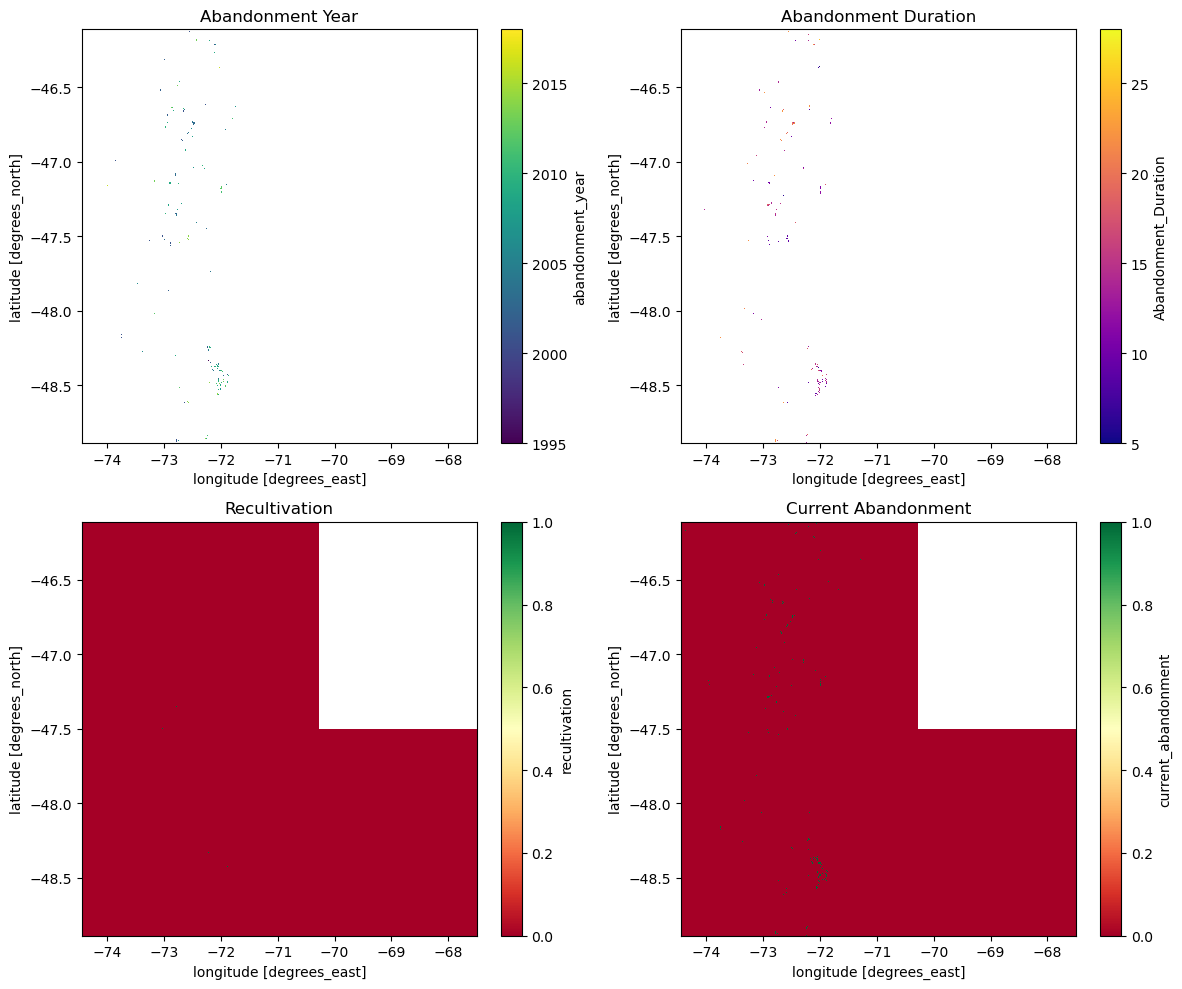

<xarray.Dataset> Size: 60MB
Dimensions:               (lat: 1000, lon: 2500)
Coordinates:
  * lat                   (lat) float64 8kB -48.89 -48.88 ... -46.12 -46.11
  * lon                   (lon) float64 20kB -74.44 -74.44 ... -67.5 -67.5
Data variables:
    abandonment_year      (lat, lon) float32 10MB ...
    Abandonment_Duration  (lat, lon) float32 10MB ...
    recultivation         (lat, lon) float64 20MB ...
    current_abandonment   (lat, lon) float64 20MB ...

In [13]:
import matplotlib.pyplot as plt
import xarray as xr

# Try opening the file with explicit engine parameter
merge_ds = xr.open_dataset('output\\abandonment_results.nc', engine='netcdf4')

# Plot the dataset
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot abandonment year
merge_ds['abandonment_year'].plot(ax=axes[0, 0], cmap='viridis')
axes[0, 0].set_title('Abandonment Year')

# Plot abandonment duration
merge_ds['Abandonment_Duration'].plot(ax=axes[0, 1], cmap='plasma')
axes[0, 1].set_title('Abandonment Duration')

# Plot recultivation
merge_ds['recultivation'].plot(ax=axes[1, 0], cmap='RdYlGn')
axes[1, 0].set_title('Recultivation')

# Plot current abandonment
merge_ds['current_abandonment'].plot(ax=axes[1, 1], cmap='RdYlGn')
axes[1, 1].set_title('Current Abandonment')

plt.tight_layout()
plt.show()

# Display the dataset
merge_ds
